##Part 1


In [201]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import pickle

In [202]:
class DroneDeliveryEnv(gym.Env):
    def __init__(self, deterministic=True):
        super(DroneDeliveryEnv, self).__init__()

        # Environment configuration
        self.grid_size = 6
        self.deterministic = deterministic
        self.start_position = (0, 0)  # Starting point
        self.goal_position = (5, 5)  # Delivery point
        self.no_fly_zones = [(3, 3), (4, 2)]  # No-fly zones

        # Action space: [Up, Down, Left, Right, Pickup, Drop-off]
        self.action_space = spaces.Discrete(6)

        # Observation space: (x, y) drone's position
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size),
            spaces.Discrete(self.grid_size)
        ))

        self.drone_position = None
        self.has_package = False
        self.time_step = 0

        # Rewards
        self.rewards = {
            "step": -1,  # Reduce step penalty to encourage exploration
            "no_fly_zone": -20,
            "delivery": 20 , # Increase delivery reward to make learning faster
            "approach_goal": 5  # Encourage getting **closer** to the goal

        }

    def reset(self):
        self.drone_position = self.start_position
        self.has_package = False
        self.time_step = 0
        return self.drone_position

    def step(self, action):
        x, y = self.drone_position
        new_x, new_y = x, y

        # Movement actions
        if action == 0:  # Up
            new_x, new_y = x - 1, y
        elif action == 1:  # Down
            new_x, new_y = x + 1, y
        elif action == 2:  # Left
            new_x, new_y = x, y - 1
        elif action == 3:  # Right
            new_x, new_y = x, y + 1
        elif action == 4:  # Pickup
            if (x, y) == self.start_position:
                self.has_package = True
        elif action == 5:  # Drop-off
            if (x, y) == self.goal_position and self.has_package:
                reward = self.rewards["delivery"]
                return (new_x, new_y), reward, True, {}

        # Checking bounds
        if new_x < 0 or new_x >= self.grid_size or new_y < 0 or new_y >= self.grid_size:
            new_x, new_y = x, y

        # Stochastic movement
        if not self.deterministic:
            if np.random.uniform(0, 1) > 0.9:
                new_x, new_y = self._apply_random_drift(new_x, new_y)

        # Check for no-fly zone
        if (new_x, new_y) in self.no_fly_zones:
            reward = self.rewards["no_fly_zone"]
        else:
            reward = self.rewards["step"]

        # Encourage movement towards the goal
        if abs(new_x - self.goal_position[0]) + abs(new_y - self.goal_position[1]) < abs(x - self.goal_position[0]) + abs(y - self.goal_position[1]):
            reward += self.rewards["approach_goal"]  # Extra reward for getting closer


        self.drone_position = (new_x, new_y)
        self.time_step += 1
        done = False
        if self.time_step >= 50:
            done = True  # Terminate after max steps

        return self.drone_position, reward, done, {}

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))

        for x, y in self.no_fly_zones:
            grid[x, y] = 3  # No-fly zone

        start_x, start_y = self.start_position
        goal_x, goal_y = self.goal_position
        drone_x, drone_y = self.drone_position

        grid[start_x, start_y] = 1  # Start point
        grid[goal_x, goal_y] = 2  # Goal point
        grid[drone_x, drone_y] = 4  # Drone's position

        fig, ax = plt.subplots(figsize=(6, 6))
        cmap = plt.get_cmap("viridis", 5)
        im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=4)

        cbar = ax.figure.colorbar(im, ax=ax, ticks=[0, 1, 2, 3, 4])
        cbar.ax.set_yticklabels(['Fly Area', 'Start', 'Goal', 'No-fly Zone', 'Drone'])

        ax.set_xticks(np.arange(-0.5, self.grid_size, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.grid_size, 1), minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax.tick_params(which="minor", bottom=False, left=False)

        for (i, j), label in np.ndenumerate(grid):
            if label == 1:
                ax.text(j, i, 'S', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            elif label == 2:
                ax.text(j, i, 'G', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            elif label == 4:
                ax.text(j, i, 'D', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

        plt.title(f"Autonomous Drone Delivery (Timestep: {self.time_step})")
        plt.show()

    def _apply_random_drift(self, x, y):
        possible_moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        drift_x, drift_y = possible_moves[np.random.randint(0, 4)]
        new_x, new_y = x + drift_x, y + drift_y

        if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
            return new_x, new_y
        return x, y


Deterministic Environment:
State: (0, 0), Reward: -1


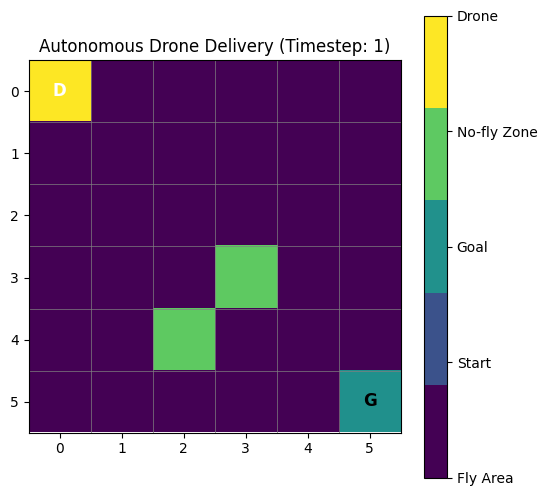

State: (0, 1), Reward: 4


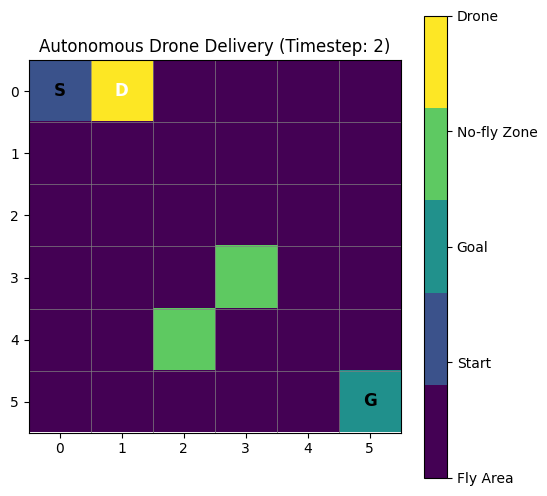

State: (1, 1), Reward: 4


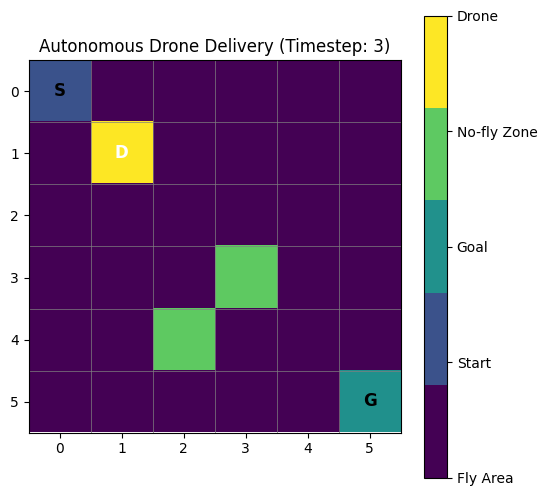

State: (1, 1), Reward: -1


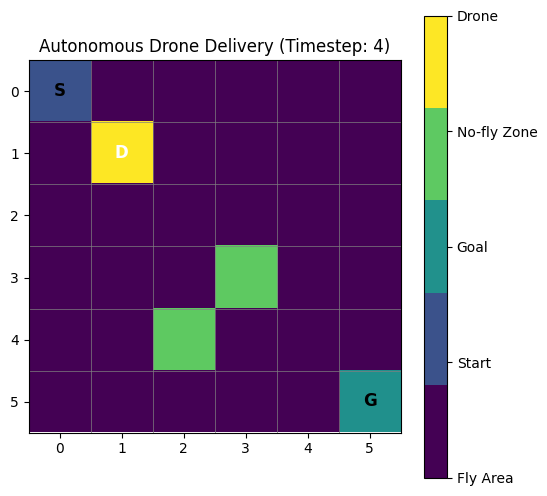

State: (1, 2), Reward: 4


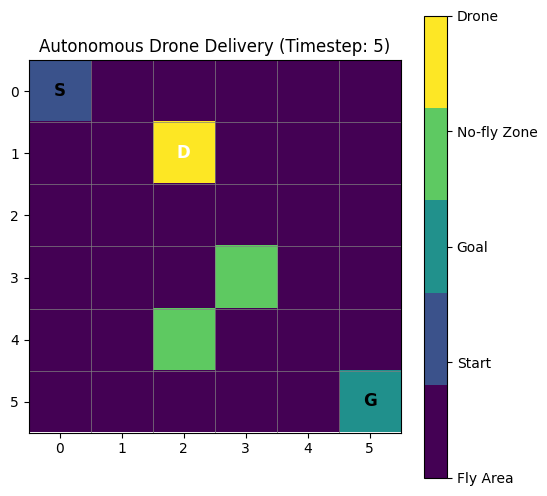

State: (2, 2), Reward: 4


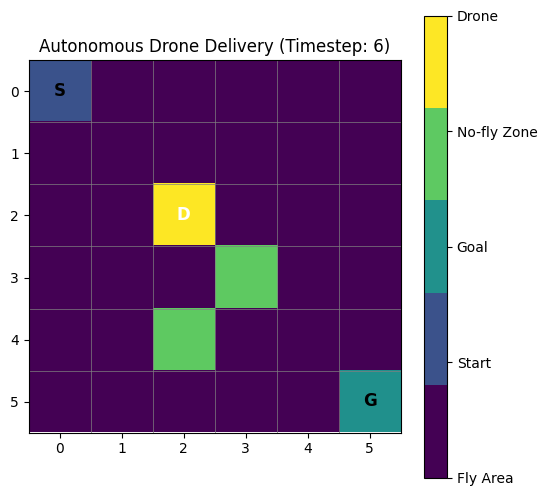

State: (2, 2), Reward: -1


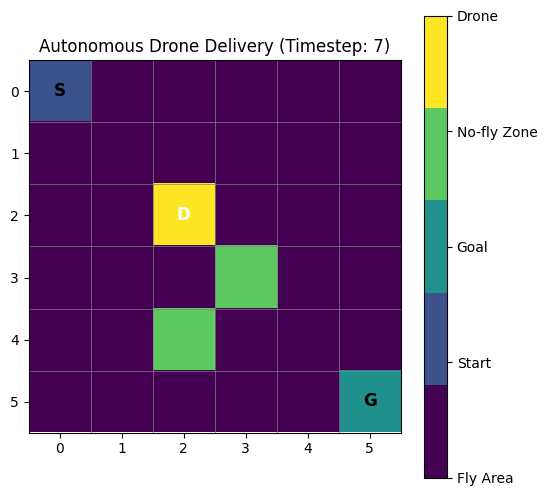

State: (3, 2), Reward: 4


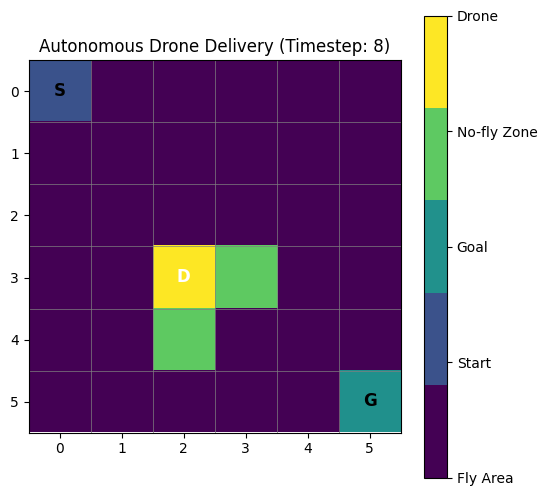

State: (4, 2), Reward: -15


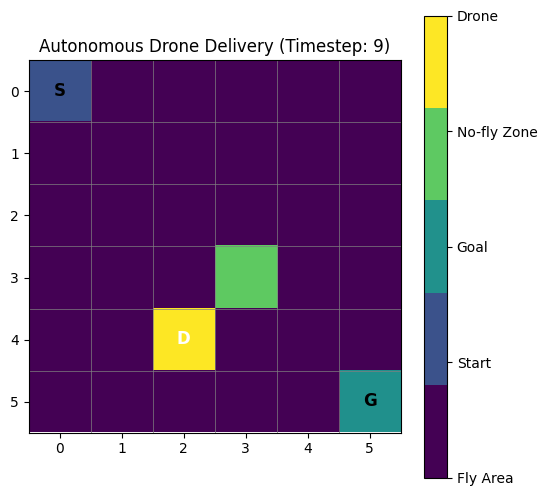

State: (3, 2), Reward: -1


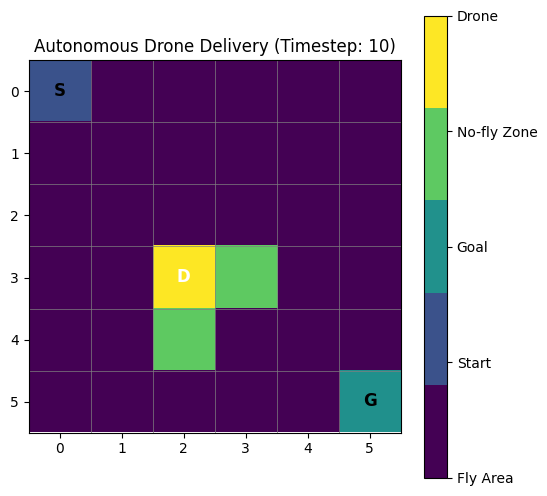

State: (2, 2), Reward: -1


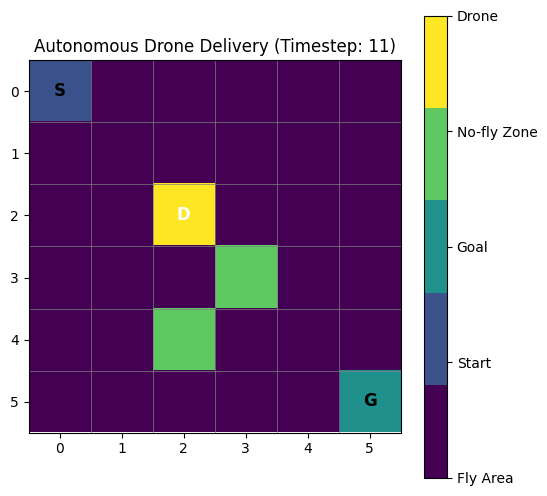

State: (3, 2), Reward: 4


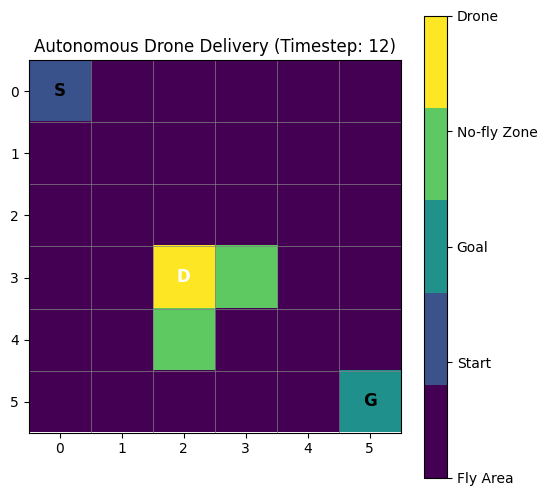

State: (3, 2), Reward: -1


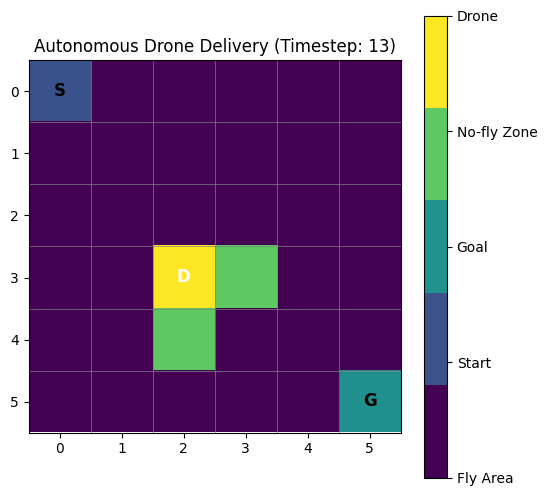

State: (3, 3), Reward: -15


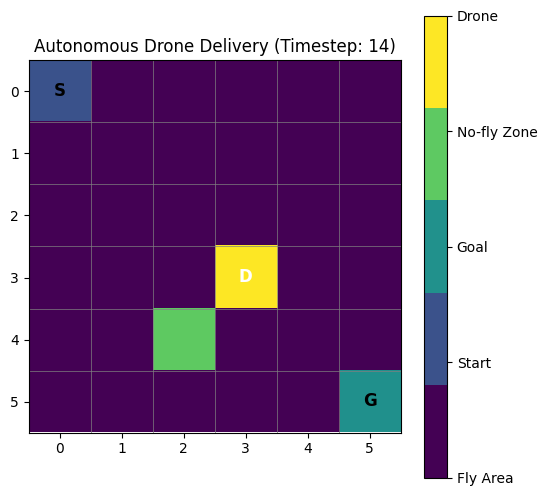

State: (3, 2), Reward: -1


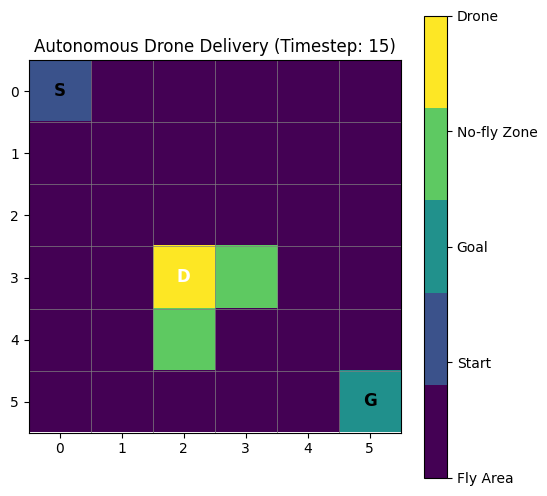

State: (3, 2), Reward: -1


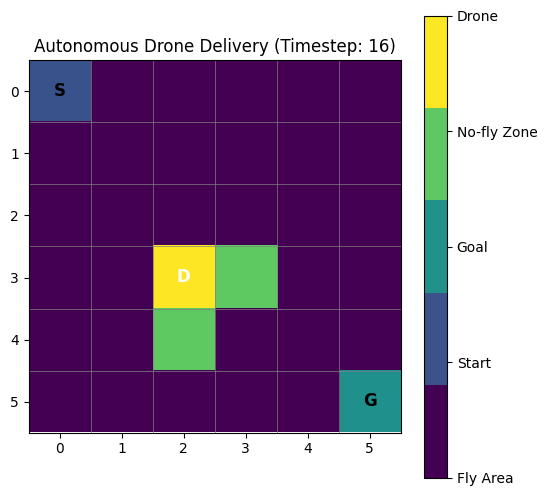

State: (4, 2), Reward: -15


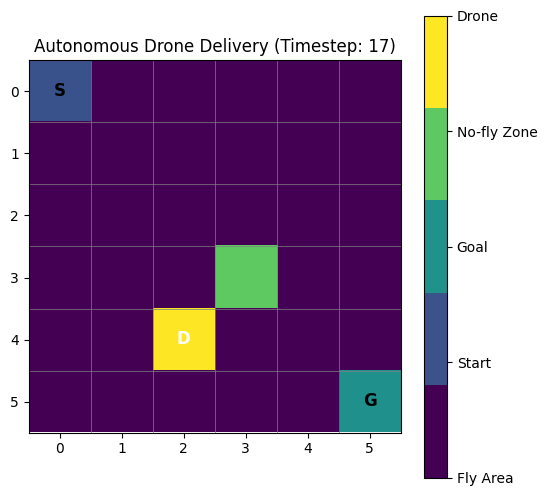

State: (5, 2), Reward: 4


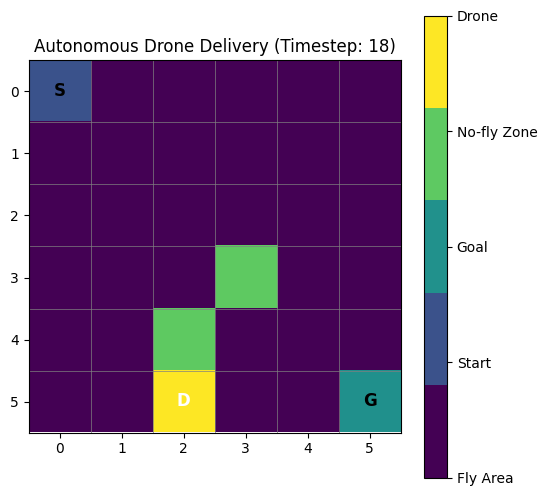

State: (5, 3), Reward: 4


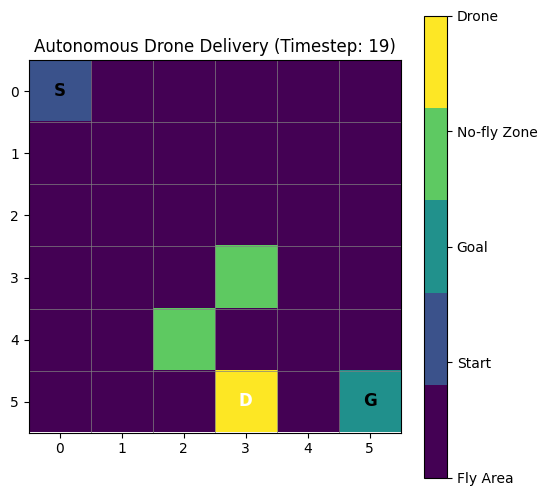

State: (5, 3), Reward: -1


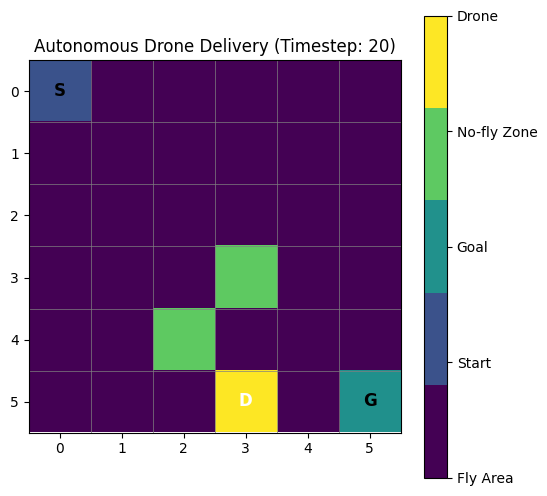

State: (5, 3), Reward: -1


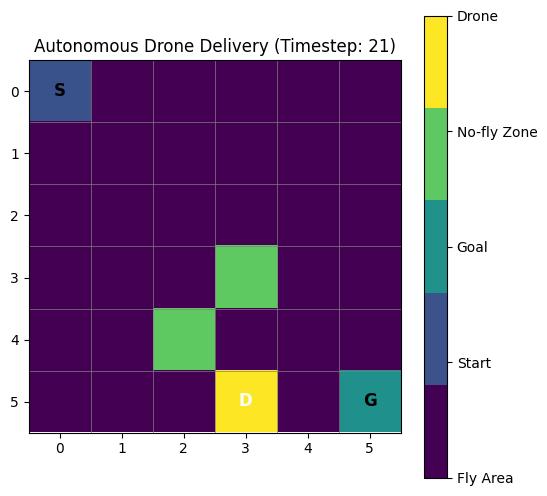

State: (5, 2), Reward: -1


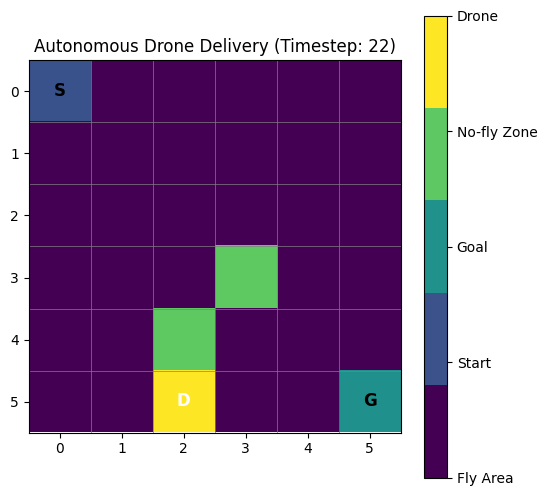

State: (5, 2), Reward: -1


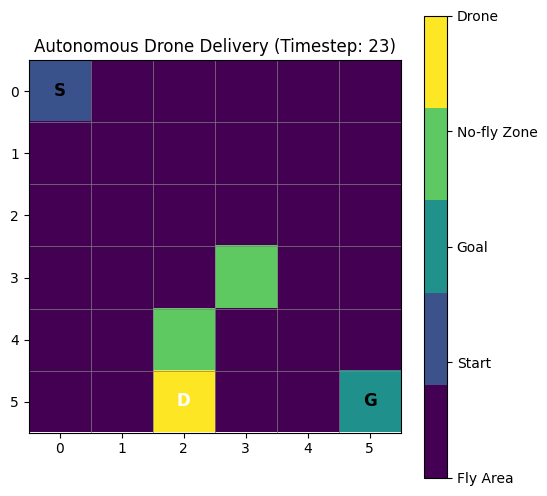

State: (5, 2), Reward: -1


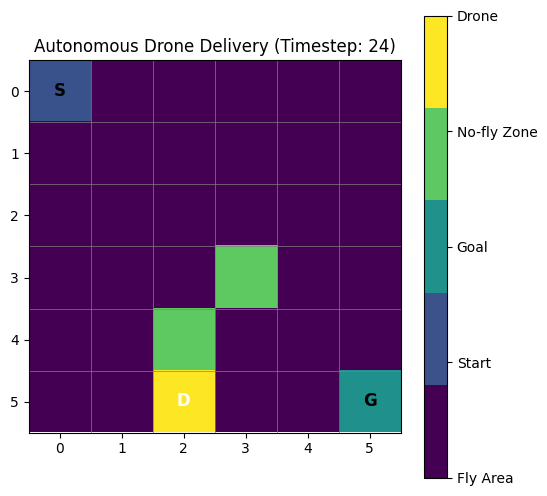

State: (5, 1), Reward: -1


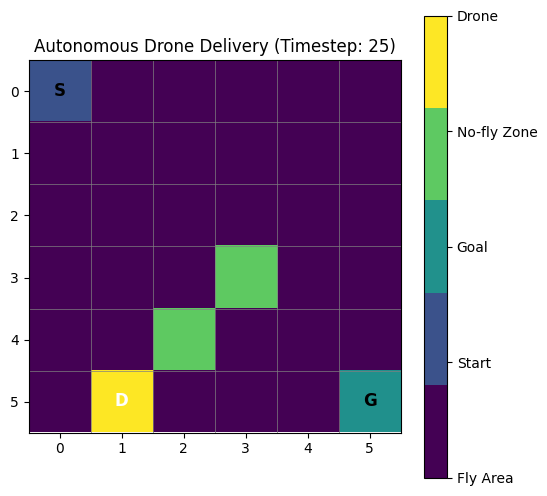

State: (5, 1), Reward: -1


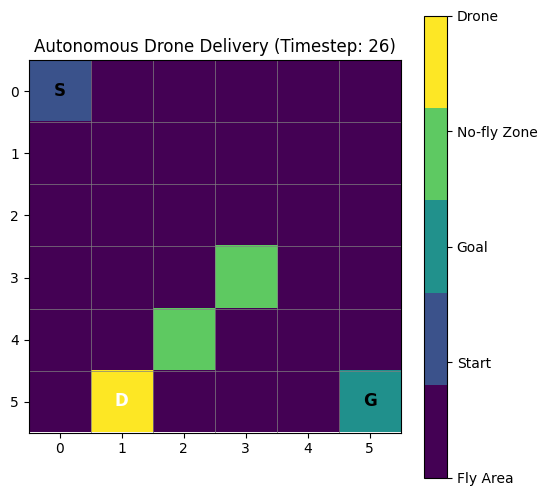

State: (5, 1), Reward: -1


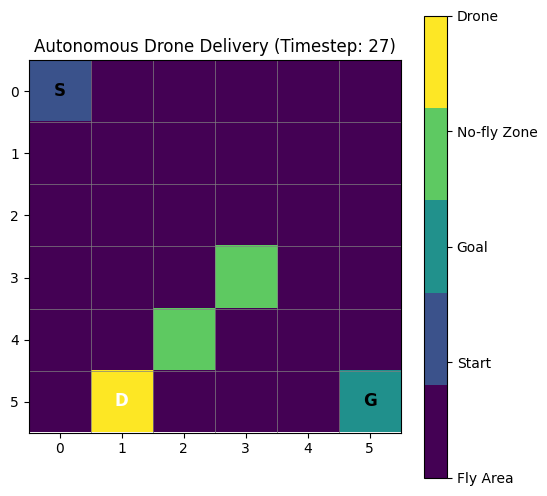

State: (4, 1), Reward: -1


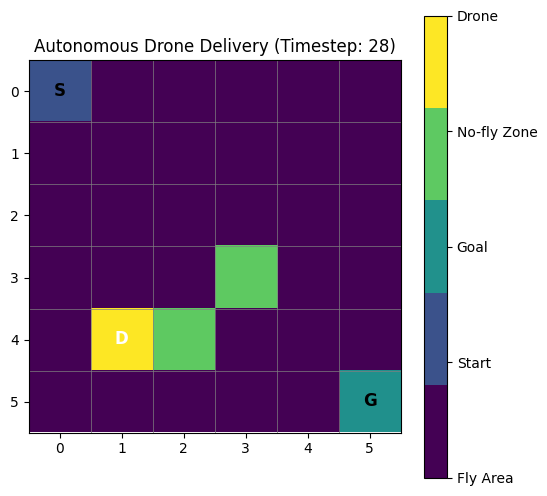

State: (4, 1), Reward: -1


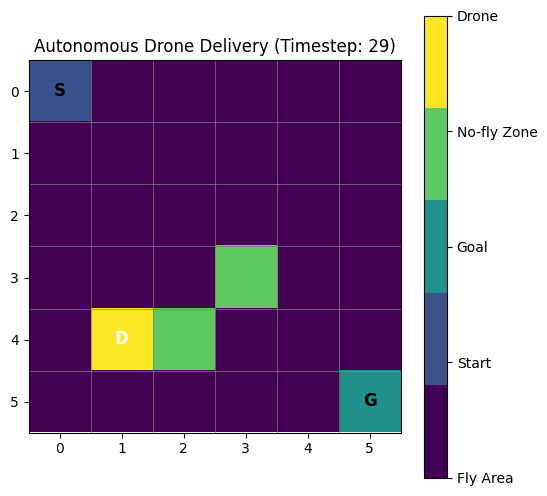

State: (4, 1), Reward: -1


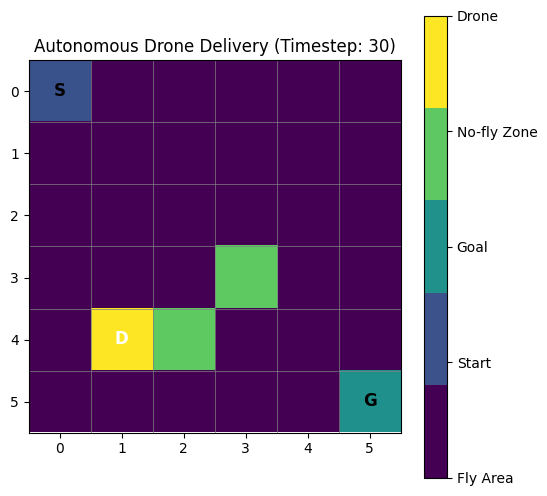


Stochastic Environment:
State: (0, 1), Reward: 4


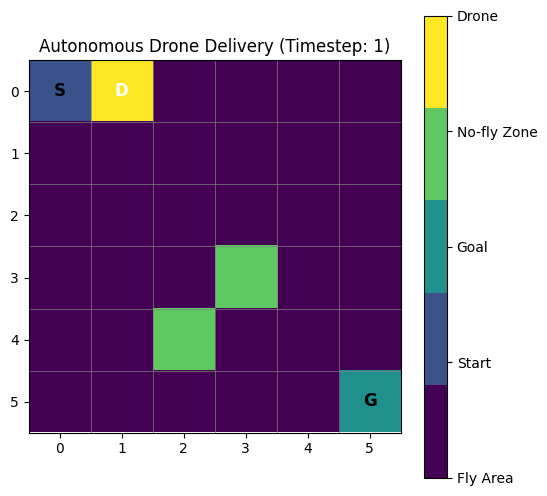

State: (0, 1), Reward: -1


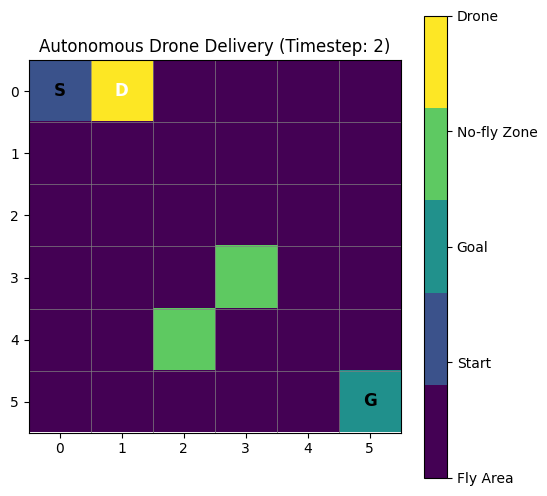

State: (0, 1), Reward: -1


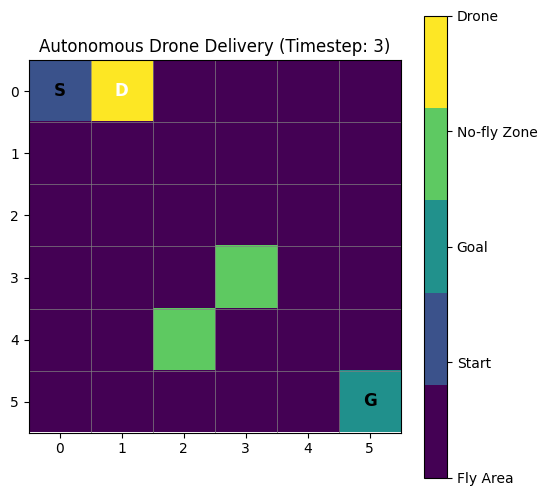

State: (1, 1), Reward: 4


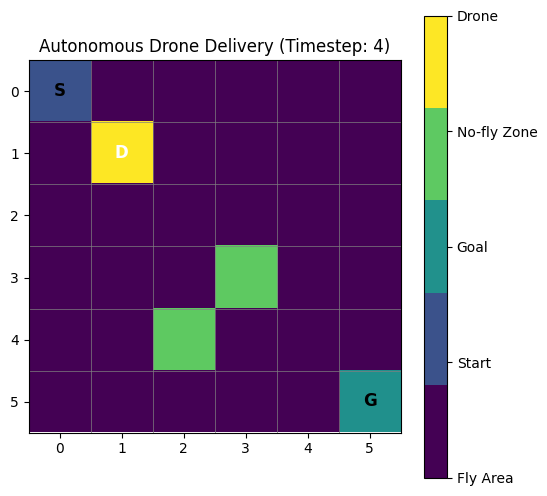

State: (1, 1), Reward: -1


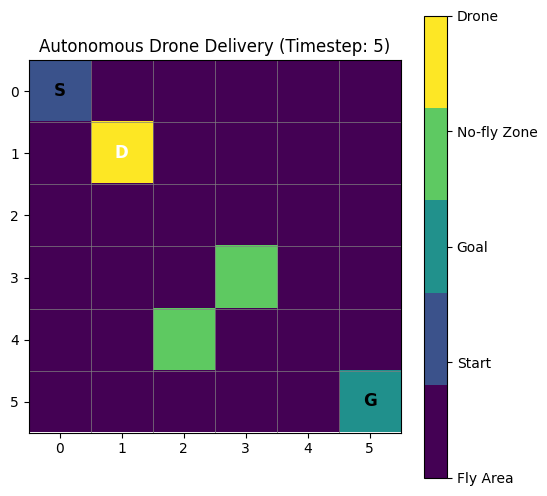

State: (1, 0), Reward: -1


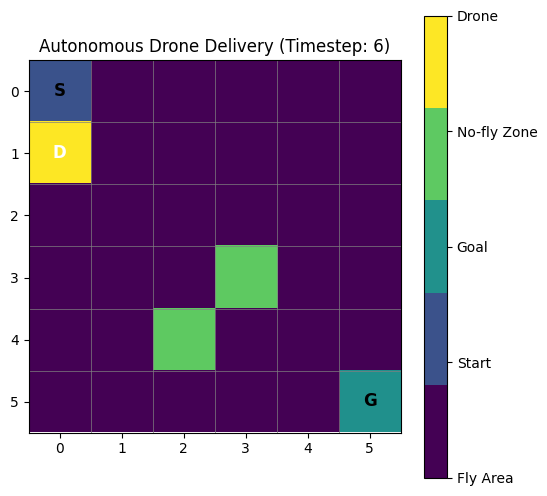

State: (1, 0), Reward: -1


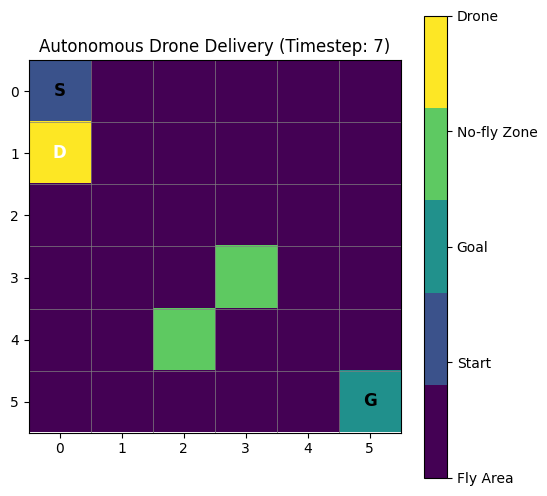

State: (0, 0), Reward: -1


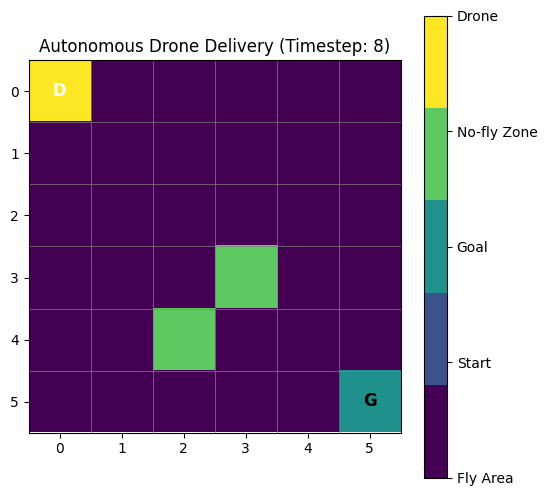

State: (0, 1), Reward: 4


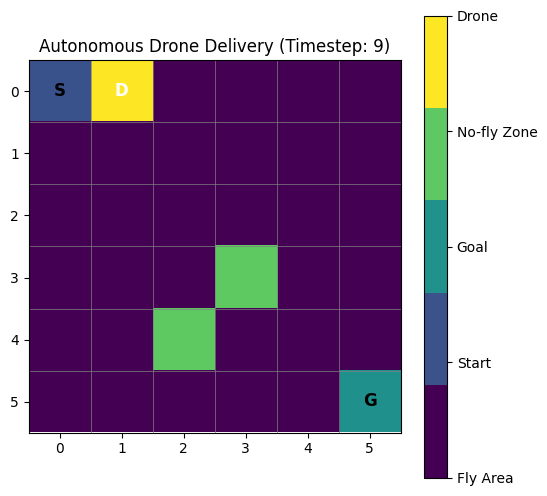

State: (0, 1), Reward: -1


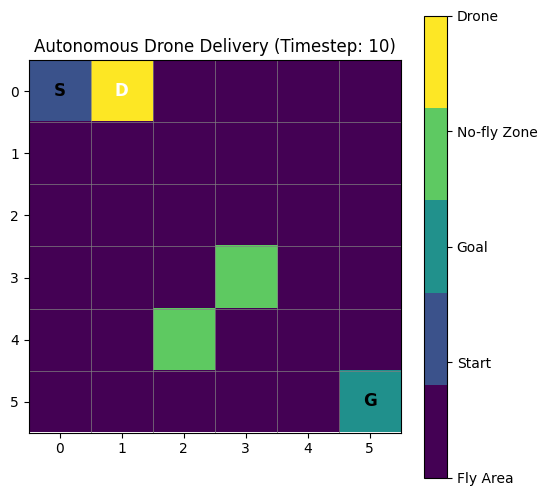

State: (0, 1), Reward: -1


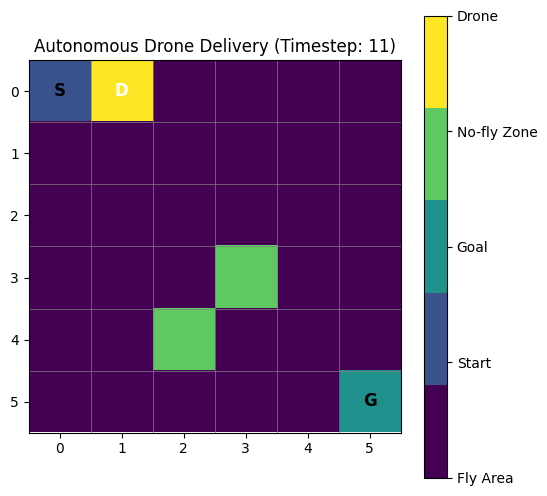

State: (1, 0), Reward: -1


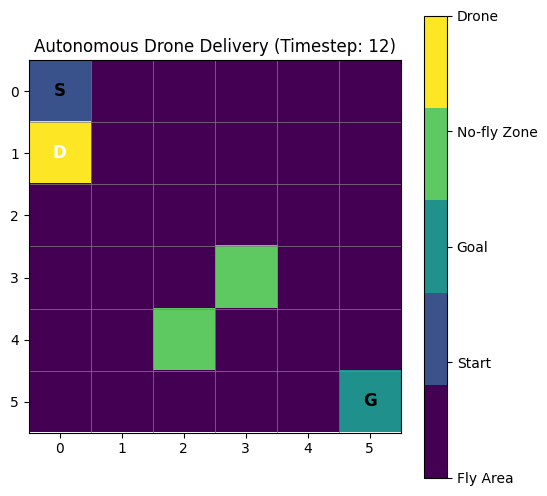

State: (1, 0), Reward: -1


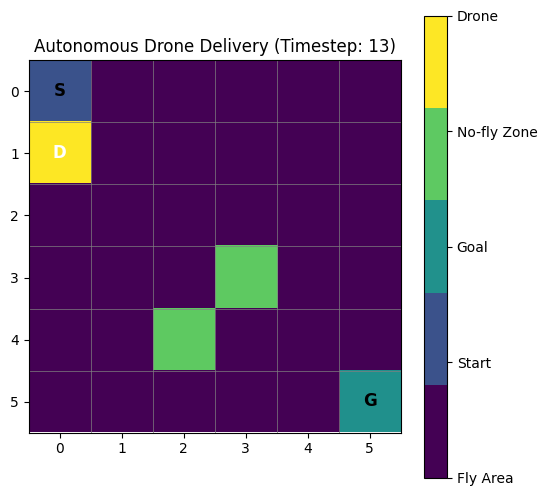

State: (1, 0), Reward: -1


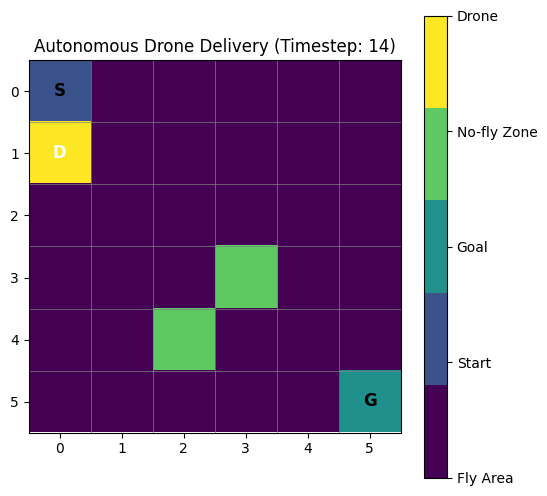

State: (1, 1), Reward: 4


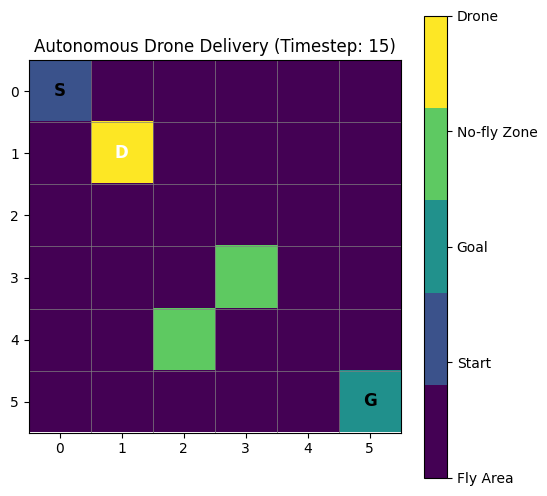

State: (1, 1), Reward: -1


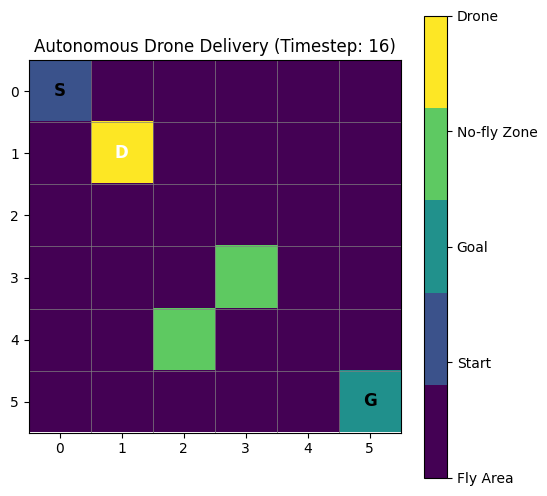

State: (2, 1), Reward: 4


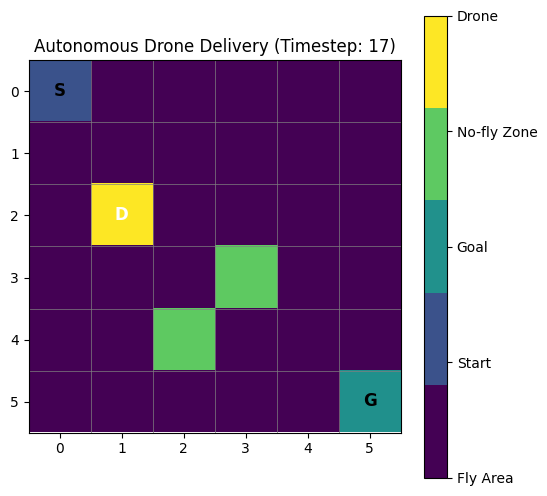

State: (2, 1), Reward: -1


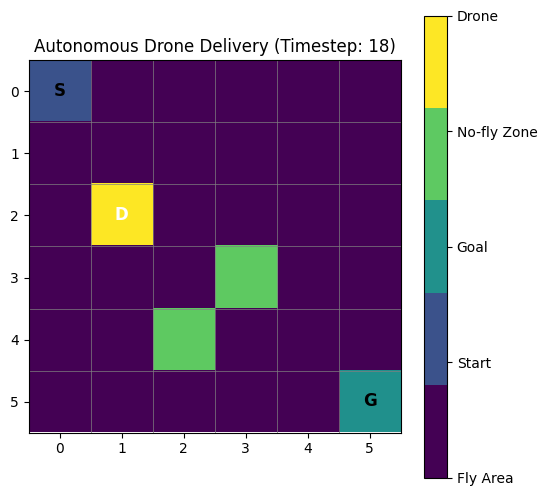

State: (1, 1), Reward: -1


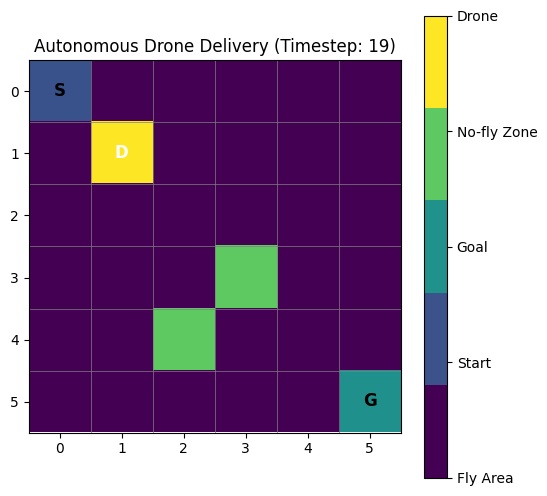

State: (2, 1), Reward: 4


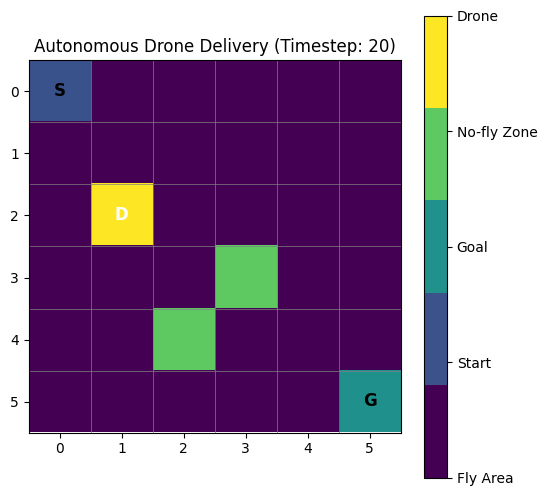

State: (3, 1), Reward: 4


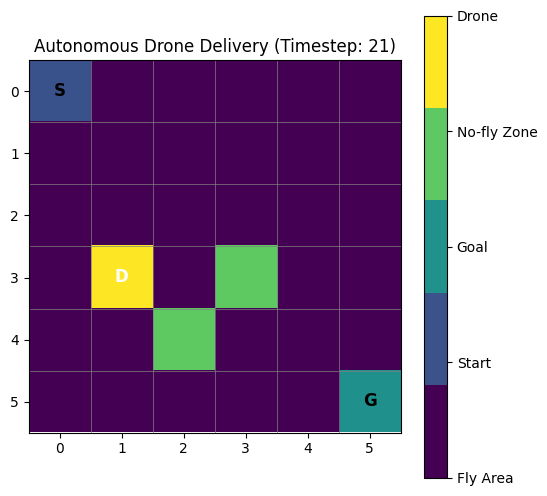

State: (3, 1), Reward: -1


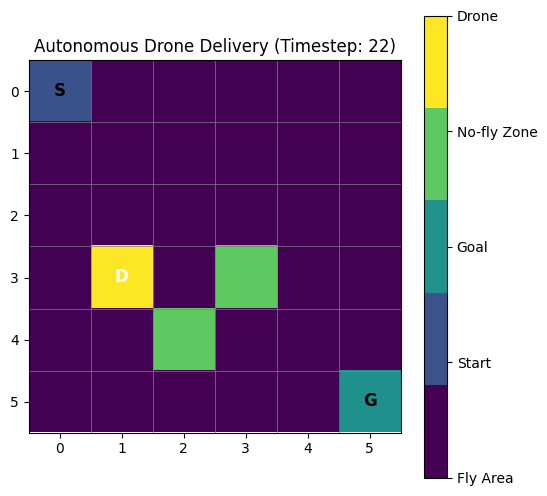

State: (3, 1), Reward: -1


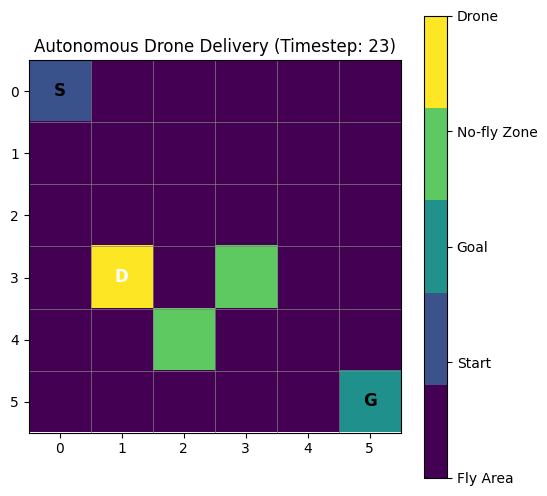

State: (3, 0), Reward: -1


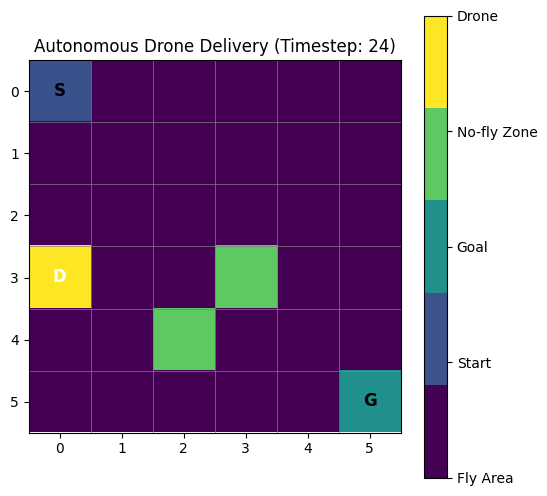

State: (3, 0), Reward: -1


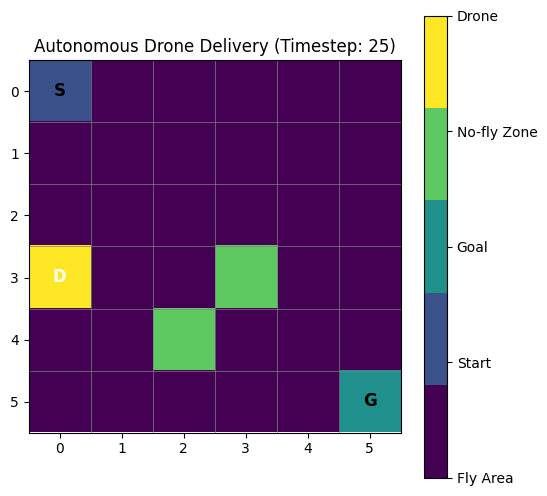

State: (3, 0), Reward: -1


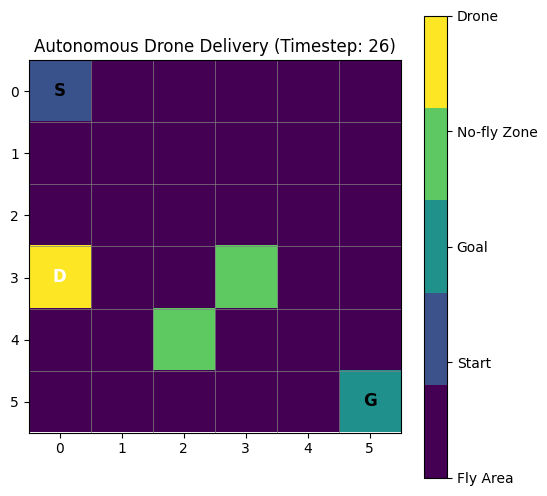

State: (5, 0), Reward: 4


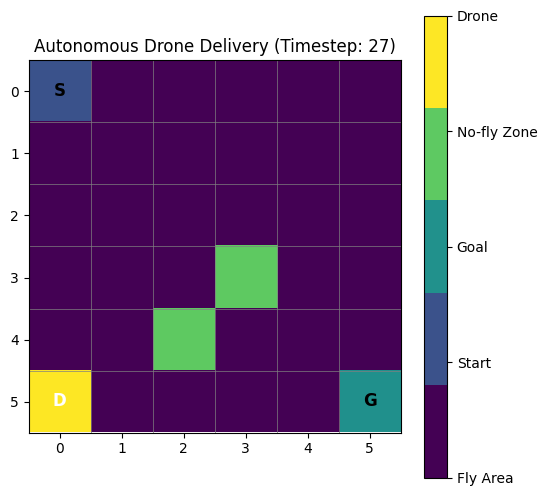

State: (5, 1), Reward: 4


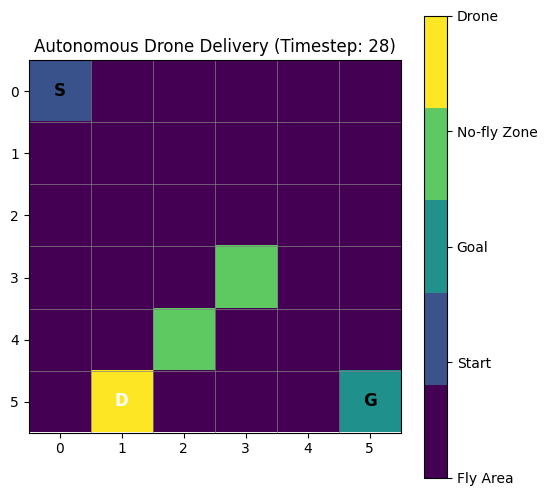

State: (5, 1), Reward: -1


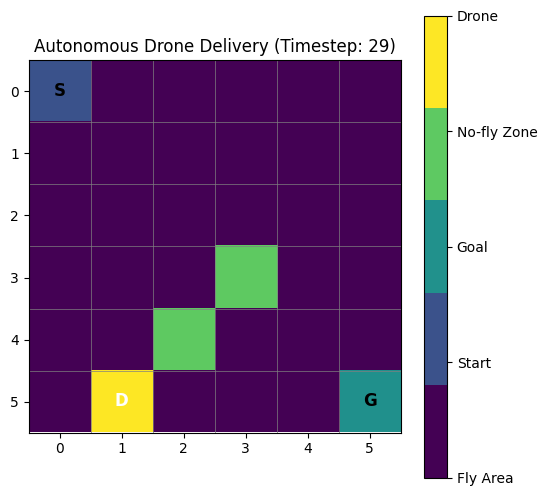

State: (5, 1), Reward: -1


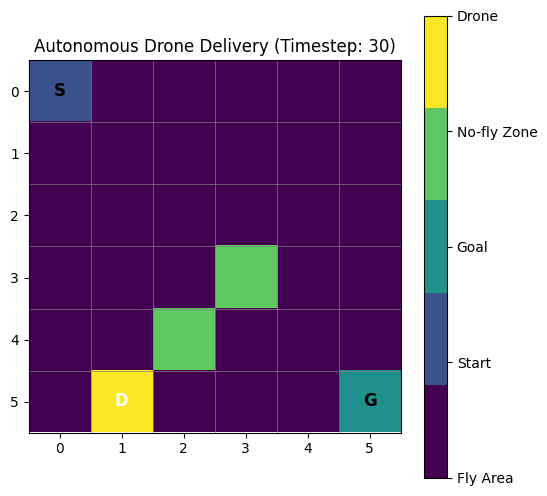

In [203]:
if __name__ == "__main__":
    # Deterministic Scenario
    env = DroneDeliveryEnv(deterministic=True)
    state = env.reset()
    print("Deterministic Environment:")
    for _ in range(30):
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        print(f"State: {state}, Reward: {reward}")
        env.render()

    # Stochastic Scenario
    env_stochastic = DroneDeliveryEnv(deterministic=False)
    state = env_stochastic.reset()
    print("\nStochastic Environment:")
    for _ in range(30):
        action = env_stochastic.action_space.sample()
        state, reward, done, _ = env_stochastic.step(action)
        print(f"State: {state}, Reward: {reward}")
        env_stochastic.render()


### Bonus Task

In [204]:
class MultiDeliveryDroneEnv(gym.Env):
    def __init__(self, max_deliveries=3, deterministic=True):
        super(MultiDeliveryDroneEnv, self).__init__()

        self.grid_size = 6
        self.deterministic = deterministic
        self.start_position = (0, 0)  # Warehouse location
        self.goal_position = (5, 5)  # First delivery location
        self.no_fly_zones = [(3, 3), (4, 2)]  # Static obstacles

        # Action space: [Up, Down, Left, Right, Pickup, Drop-off]
        self.action_space = spaces.Discrete(6)

        # Observation space: drone position and delivery count
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size),
            spaces.Discrete(self.grid_size),
            spaces.Discrete(max_deliveries + 1)
        ))

        self.drone_position = None
        self.has_package = False
        self.time_step = 0
        self.max_deliveries = max_deliveries
        self.delivery_count = 0

        # Rewards
        self.rewards = {
            "step": -1,
            "no_fly_zone": -20,
            "delivery": 20
        }

    def reset(self):
        self.drone_position = self.start_position
        self.has_package = False
        self.time_step = 0
        self.delivery_count = 0
        self.goal_position = self._generate_new_goal()
        return (self.drone_position[0], self.drone_position[1], self.delivery_count)

    def step(self, action):
        x, y = self.drone_position

        if action == 0:  # Up
            new_x, new_y = x - 1, y
        elif action == 1:  # Down
            new_x, new_y = x + 1, y
        elif action == 2:  # Left
            new_x, new_y = x, y - 1
        elif action == 3:  # Right
            new_x, new_y = x, y + 1
        elif action == 4:  # Pickup
            if (x, y) == self.start_position:
                self.has_package = True
            new_x, new_y = x, y
        elif action == 5:  # Drop-off
            if (x, y) == self.goal_position and self.has_package:
                reward = self.rewards["delivery"]
                self.delivery_count += 1
                self.has_package = False

                if self.delivery_count >= self.max_deliveries:
                    return (new_x, new_y, self.delivery_count), reward, True, {}

                self.drone_position = self.start_position
                self.goal_position = self._generate_new_goal()
                return (self.drone_position[0], self.drone_position[1], self.delivery_count), reward, False, {}

            new_x, new_y = x, y

        if new_x < 0 or new_x >= self.grid_size or new_y < 0 or new_y >= self.grid_size:
            new_x, new_y = x, y

        # Stochastic movement
        if not self.deterministic:
            if np.random.uniform(0, 1) > 0.9:
                new_x, new_y = self._apply_random_drift(new_x, new_y)

        # Check for no-fly zones
        if (new_x, new_y) in self.no_fly_zones:
            reward = self.rewards["no_fly_zone"]
        else:
            reward = self.rewards["step"]

        self.drone_position = (new_x, new_y)
        self.time_step += 1
        done = False

        return (new_x, new_y, self.delivery_count), reward, done, {}

    def _generate_new_goal(self):
        while True:
            goal_x = np.random.randint(0, self.grid_size)
            goal_y = np.random.randint(0, self.grid_size)
            if (goal_x, goal_y) != self.start_position and (goal_x, goal_y) not in self.no_fly_zones:
                return (goal_x, goal_y)

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))

        for x, y in self.no_fly_zones:
            grid[x, y] = 3

        start_x, start_y = self.start_position
        goal_x, goal_y = self.goal_position
        drone_x, drone_y = self.drone_position

        grid[start_x, start_y] = 1
        grid[goal_x, goal_y] = 2
        grid[drone_x, drone_y] = 4

        fig, ax = plt.subplots(figsize=(6, 6))
        cmap = plt.get_cmap("viridis", 5)
        im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=4)

        cbar = ax.figure.colorbar(im, ax=ax, ticks=[0, 1, 2, 3, 4])
        cbar.ax.set_yticklabels(['Empty', 'Start', 'Goal', 'No-fly Zone', 'Drone'])

        for (i, j), label in np.ndenumerate(grid):
            if label == 1:
                ax.text(j, i, 'S', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            elif label == 2:
                ax.text(j, i, 'G', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            elif label == 4:
                ax.text(j, i, 'D', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

        plt.title(f"Deliveries Completed: {self.delivery_count}/{self.max_deliveries}, Time-step: {self.time_step}")
        plt.show()

    def _apply_random_drift(self, x, y):
        possible_moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        drift_x, drift_y = possible_moves[np.random.randint(0, 4)]
        new_x, new_y = x + drift_x, y + drift_y

        if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
            return new_x, new_y
        return x, y


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Multiple Deliveries Environment:
State: (0, 0, 0), Reward: -1


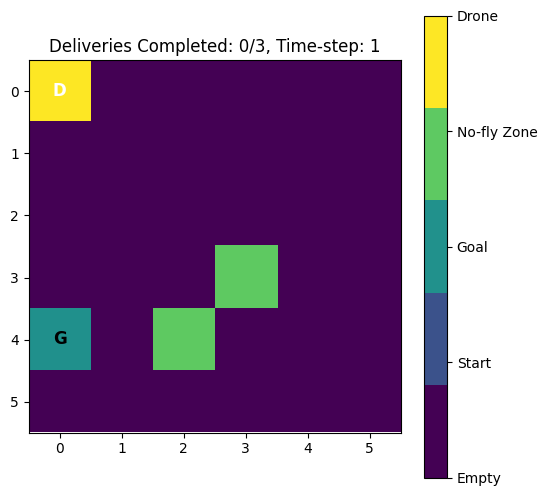

State: (0, 1, 0), Reward: -1


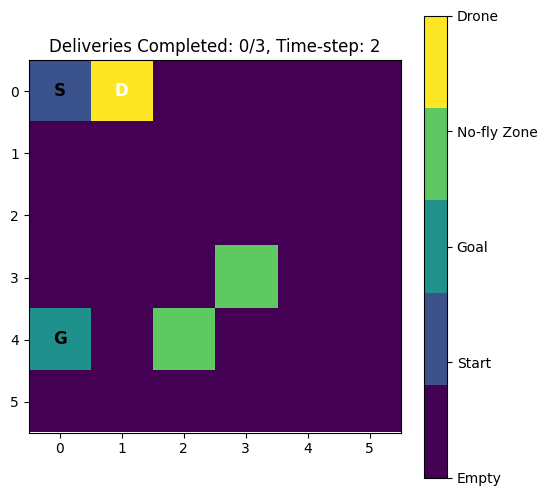

State: (0, 1, 0), Reward: -1


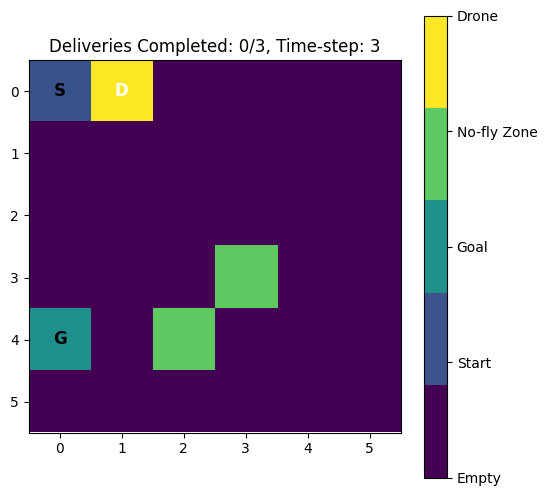

State: (0, 2, 0), Reward: -1


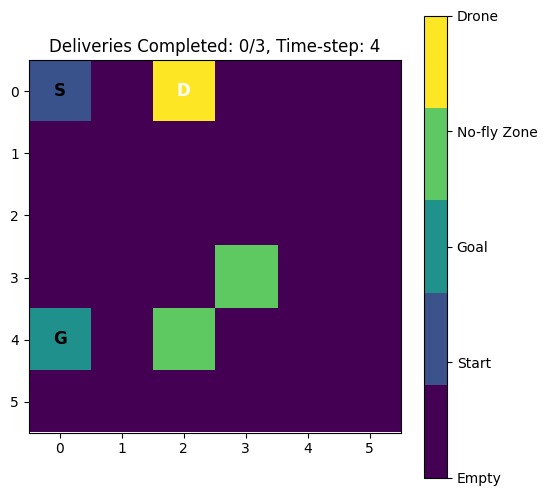

State: (0, 2, 0), Reward: -1


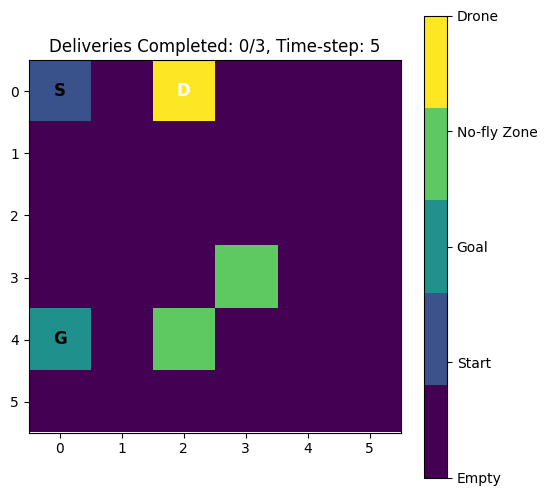

State: (1, 2, 0), Reward: -1


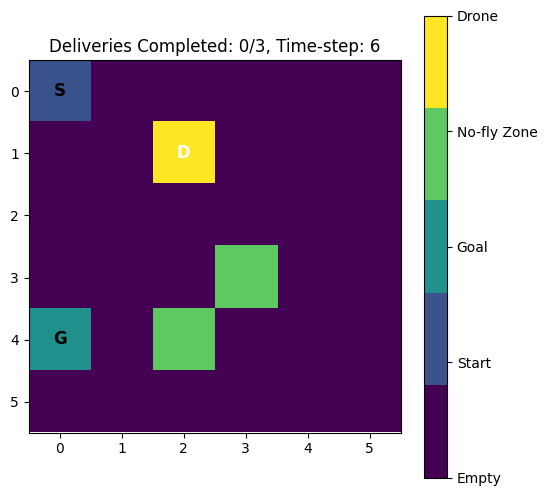

State: (1, 2, 0), Reward: -1


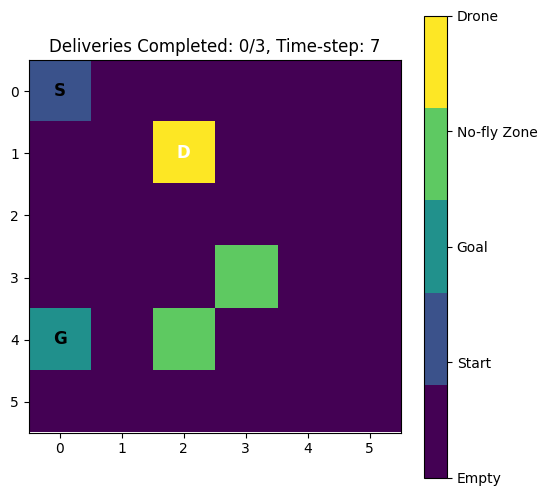

State: (0, 2, 0), Reward: -1


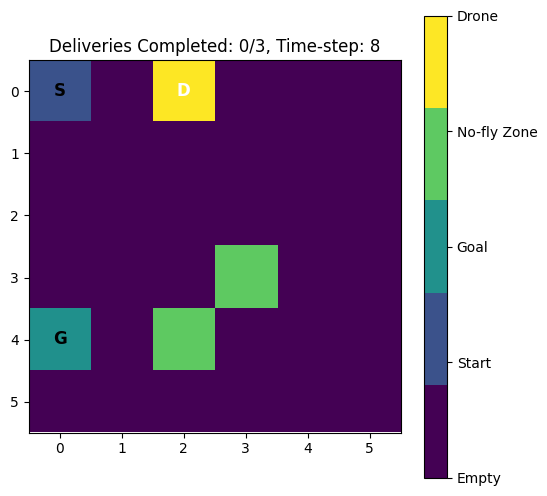

State: (1, 2, 0), Reward: -1


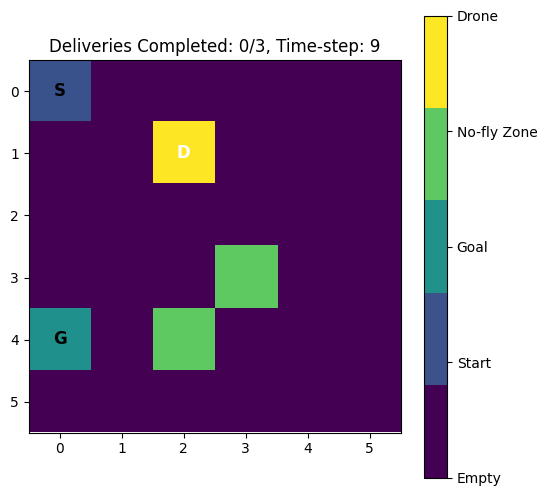

State: (1, 1, 0), Reward: -1


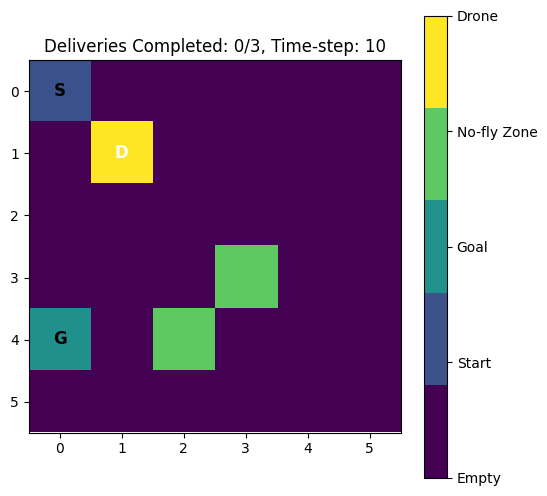

State: (0, 1, 0), Reward: -1


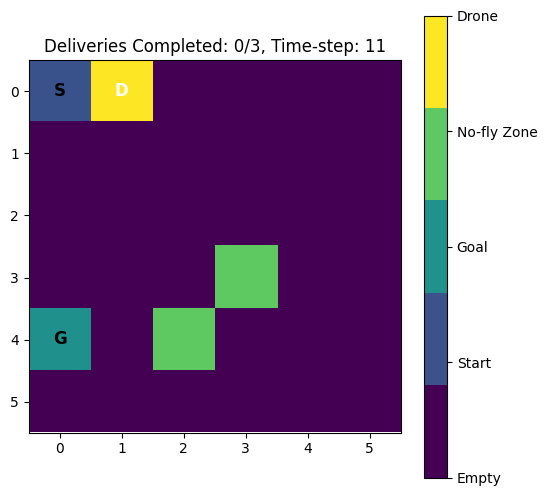

State: (0, 2, 0), Reward: -1


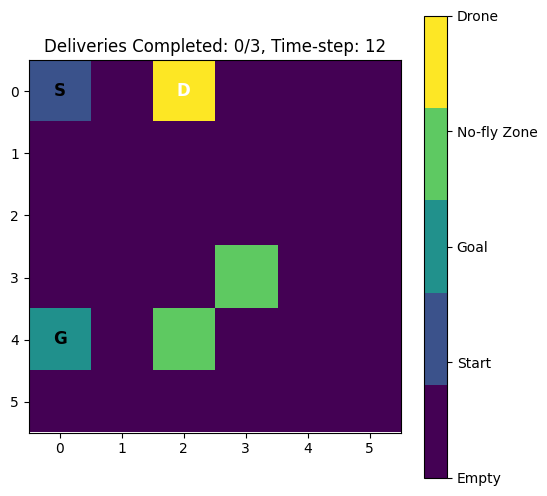

State: (0, 2, 0), Reward: -1


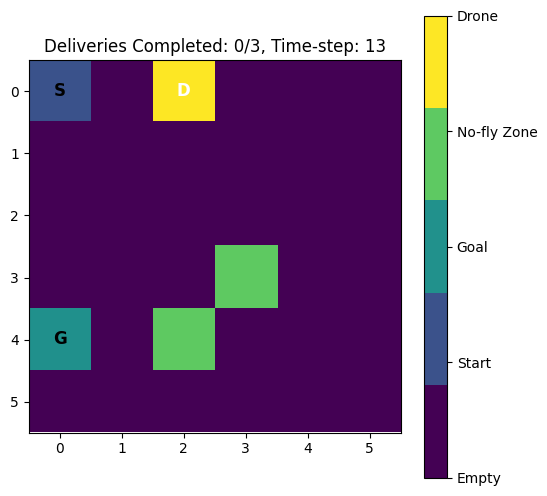

State: (0, 2, 0), Reward: -1


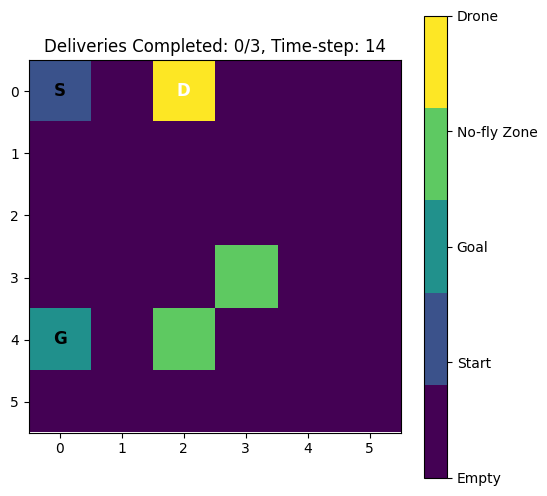

State: (1, 2, 0), Reward: -1


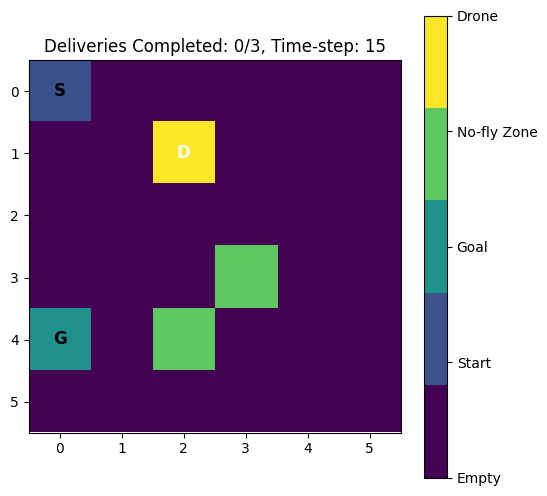

State: (0, 2, 0), Reward: -1


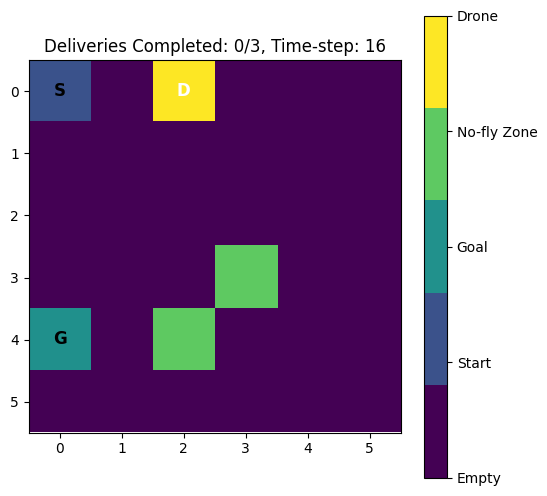

State: (1, 2, 0), Reward: -1


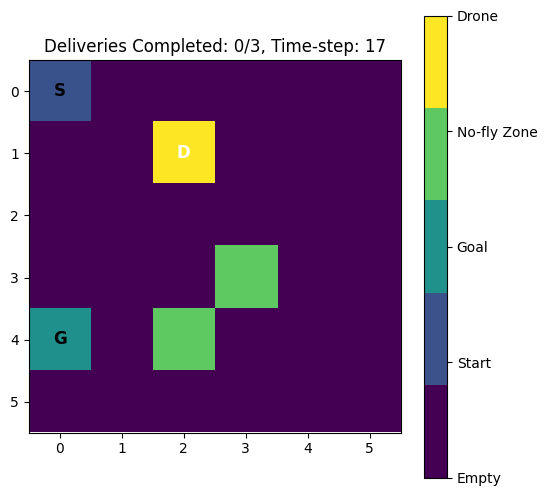

State: (0, 2, 0), Reward: -1


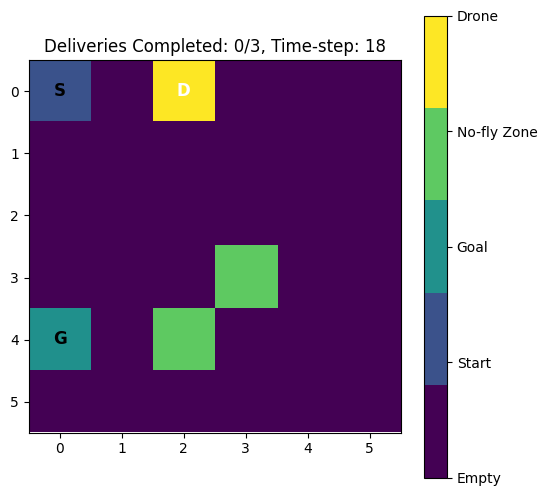

State: (0, 2, 0), Reward: -1


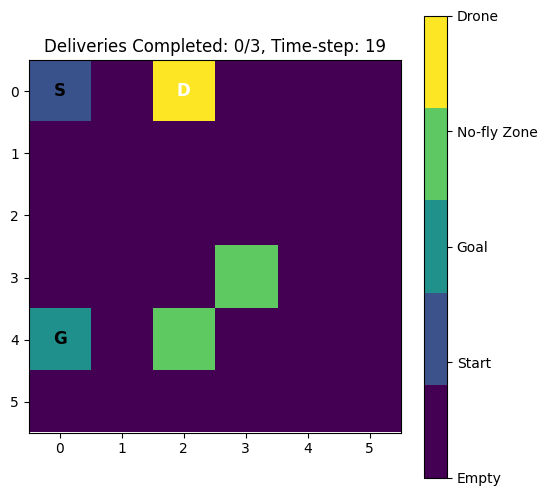

State: (0, 2, 0), Reward: -1


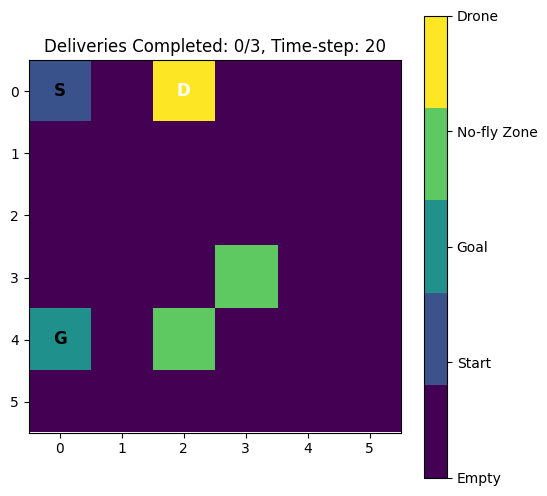

State: (1, 2, 0), Reward: -1


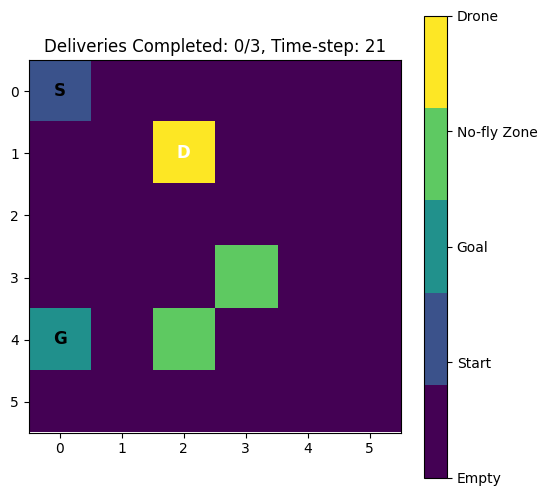

State: (1, 1, 0), Reward: -1


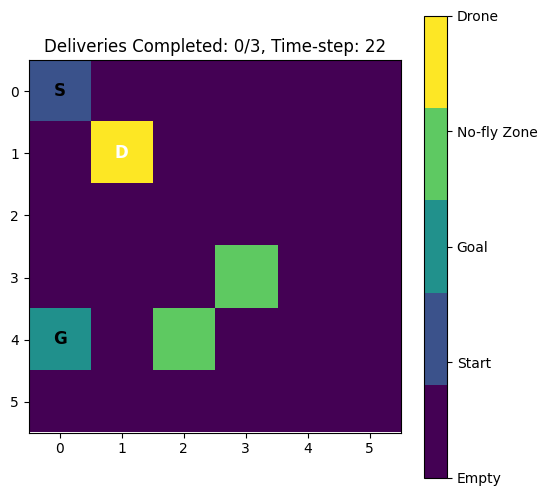

State: (1, 1, 0), Reward: -1


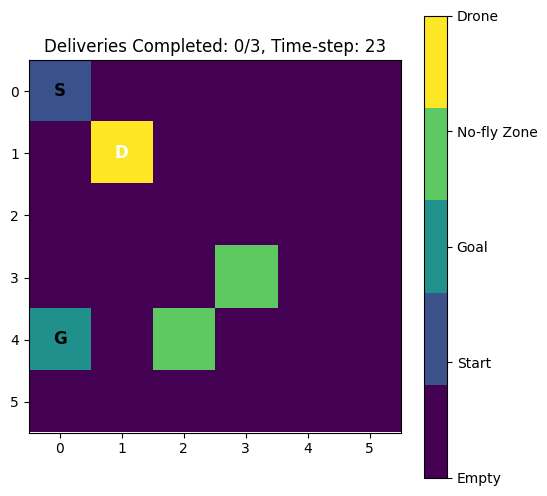

State: (0, 1, 0), Reward: -1


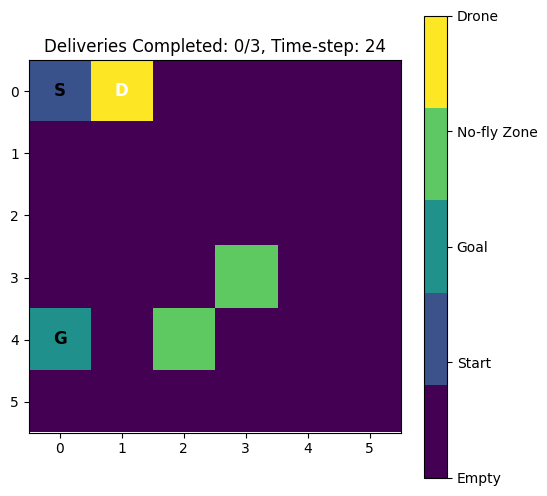

State: (0, 2, 0), Reward: -1


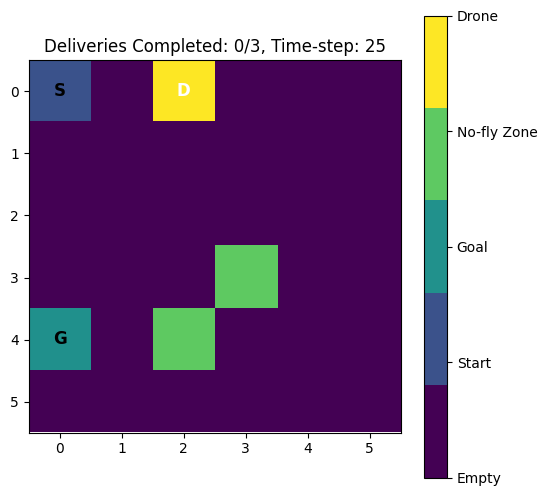

State: (1, 2, 0), Reward: -1


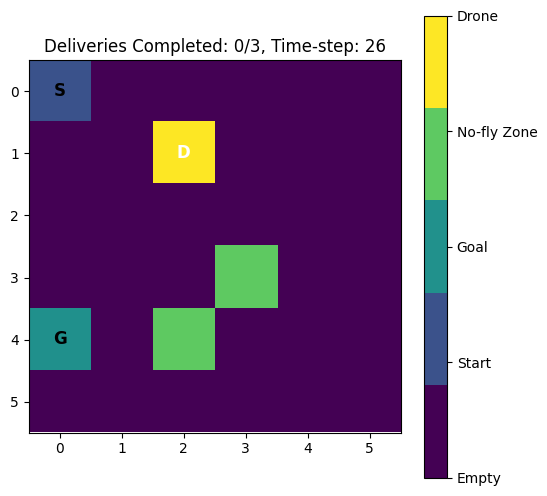

State: (2, 2, 0), Reward: -1


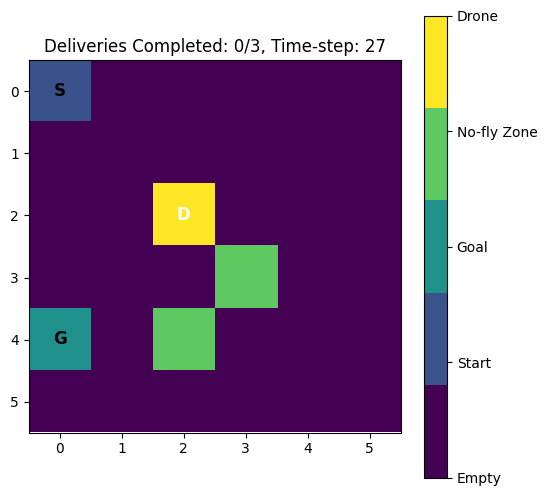

State: (2, 1, 0), Reward: -1


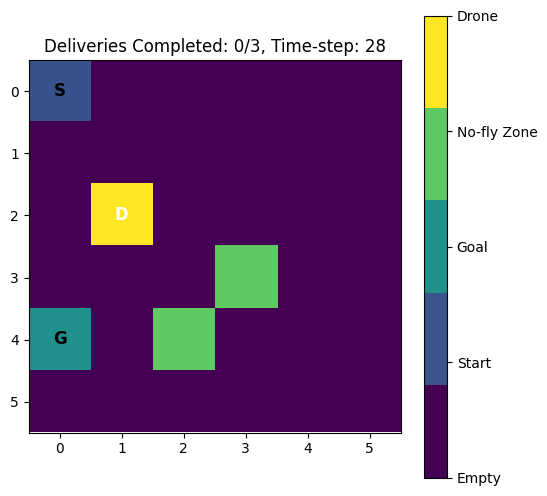

State: (1, 1, 0), Reward: -1


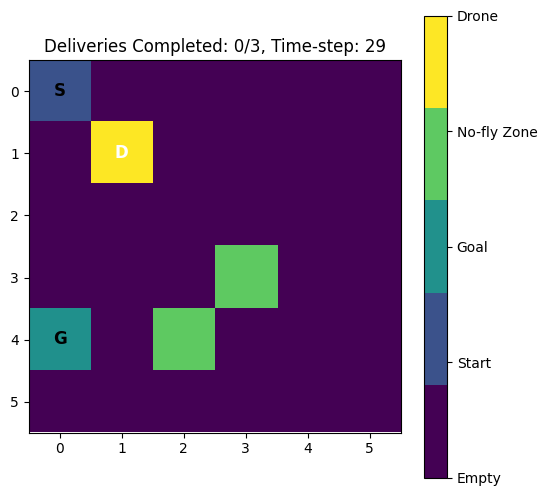

State: (1, 1, 0), Reward: -1


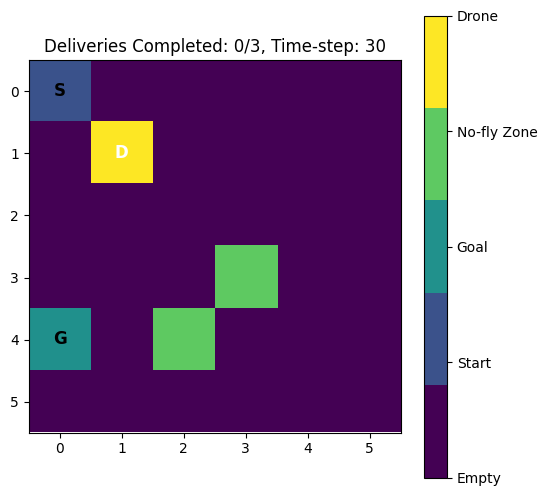

State: (1, 1, 0), Reward: -1


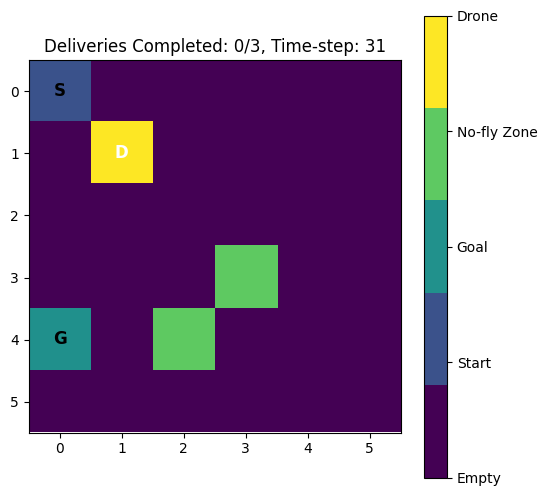

State: (1, 1, 0), Reward: -1


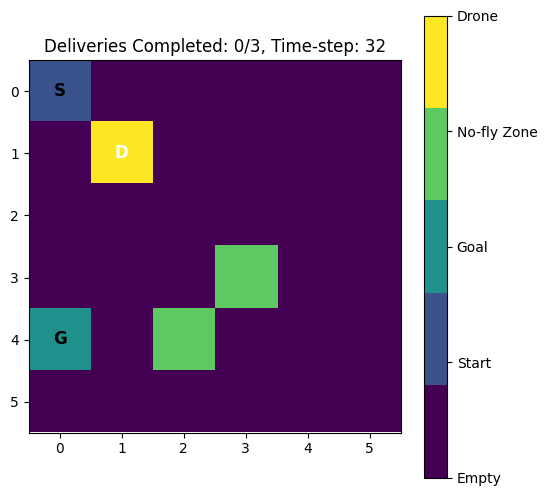

State: (2, 1, 0), Reward: -1


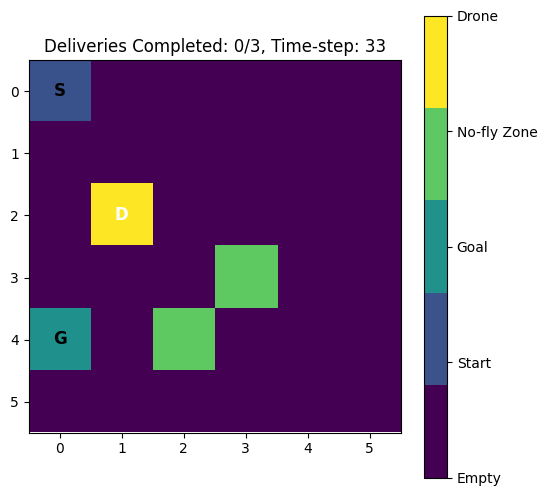

State: (2, 2, 0), Reward: -1


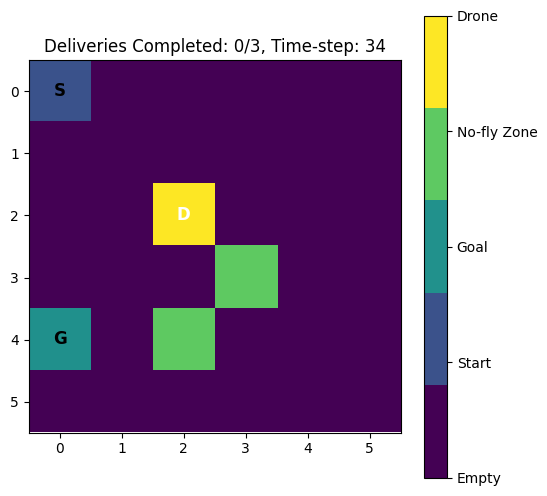

State: (2, 2, 0), Reward: -1


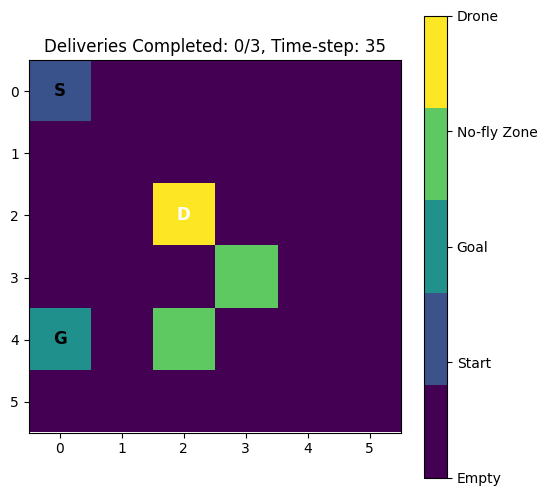

State: (2, 2, 0), Reward: -1


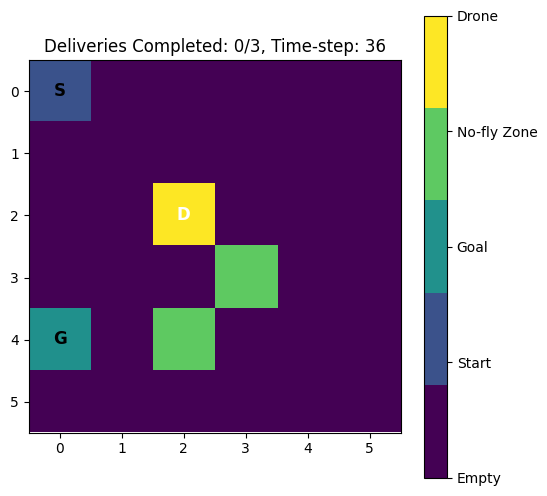

State: (2, 1, 0), Reward: -1


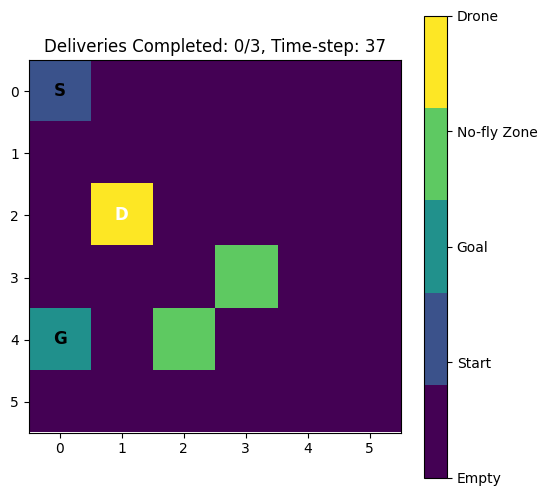

State: (2, 0, 0), Reward: -1


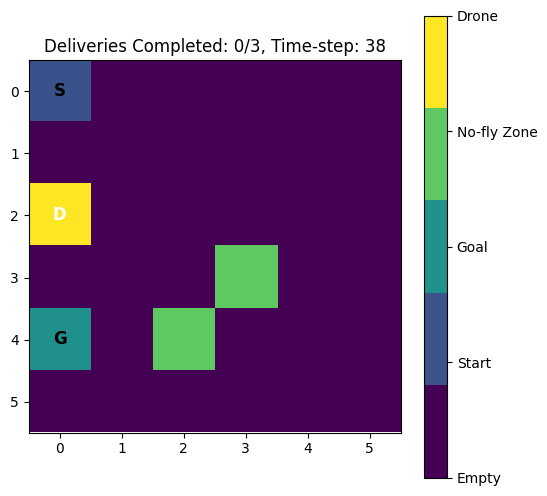

State: (2, 1, 0), Reward: -1


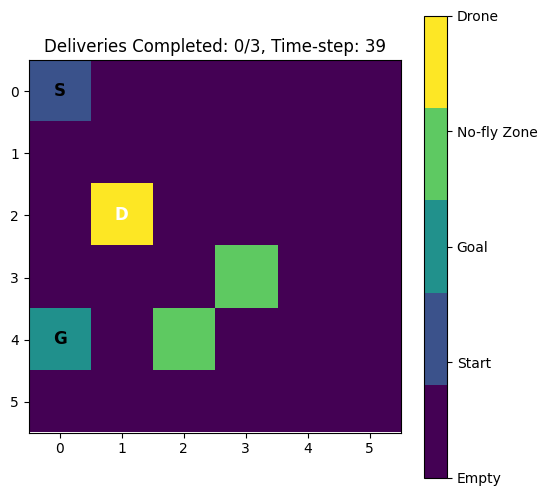

State: (2, 2, 0), Reward: -1


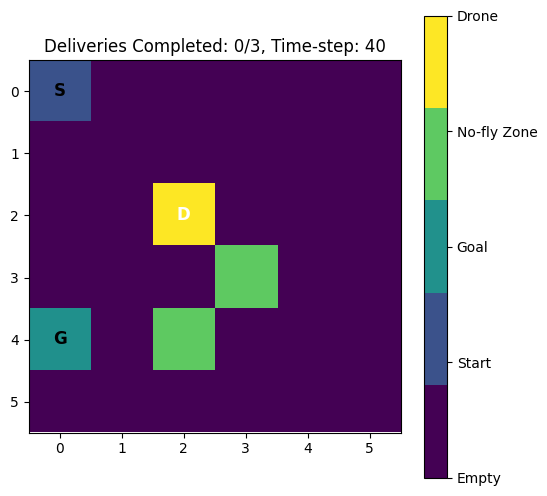

State: (2, 2, 0), Reward: -1


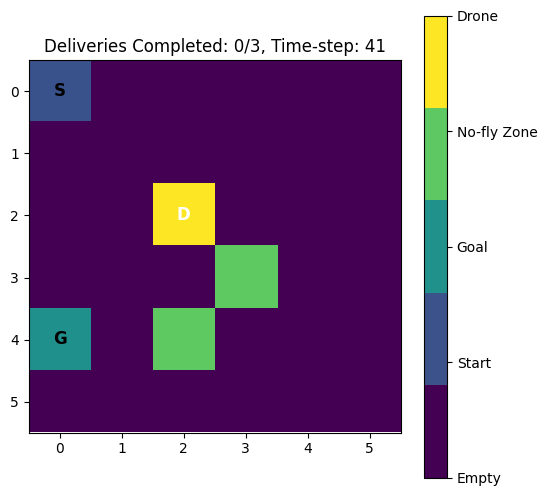

State: (3, 2, 0), Reward: -1


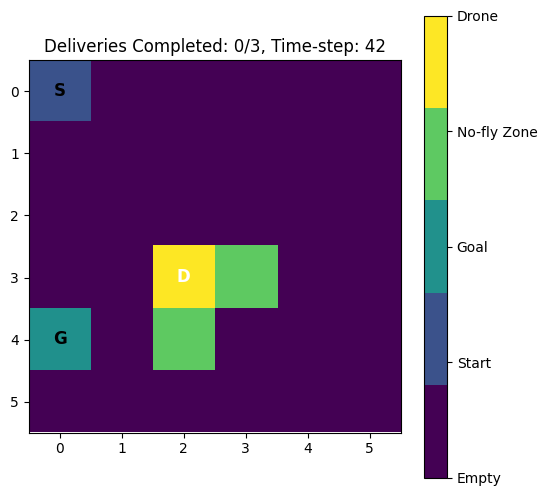

State: (3, 2, 0), Reward: -1


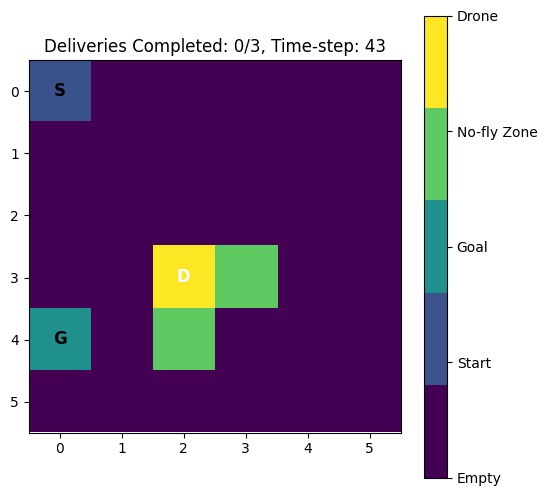

State: (4, 2, 0), Reward: -20


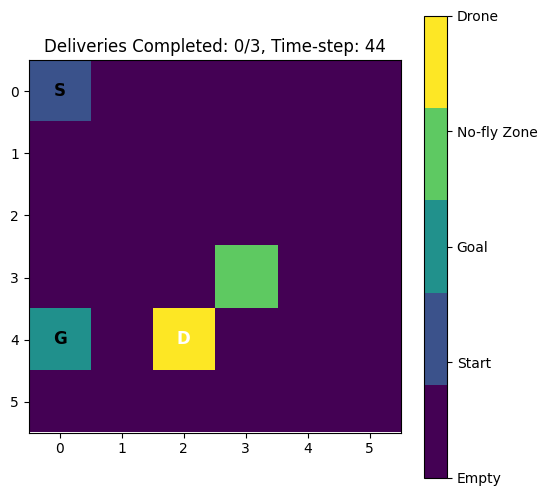

State: (4, 2, 0), Reward: -20


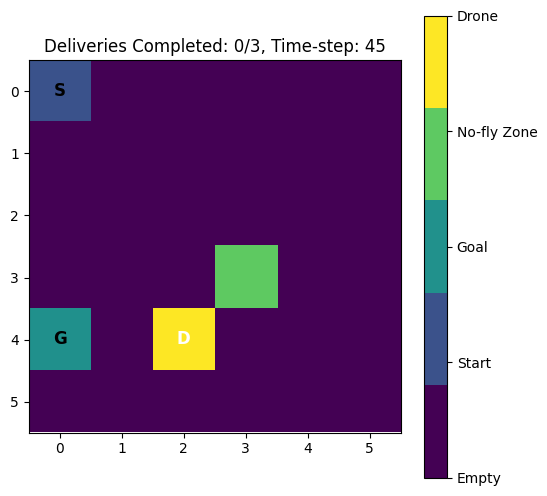

State: (5, 2, 0), Reward: -1


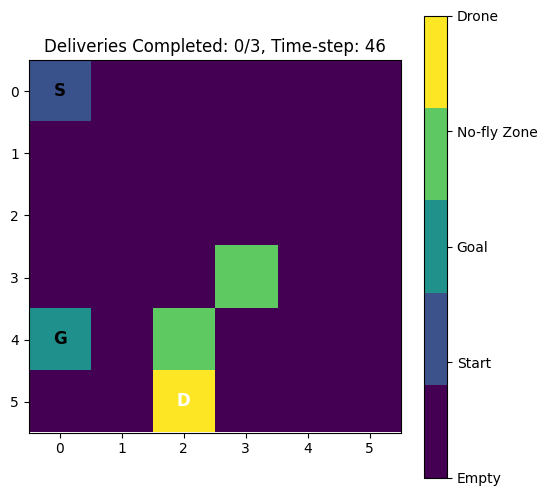

State: (5, 2, 0), Reward: -1


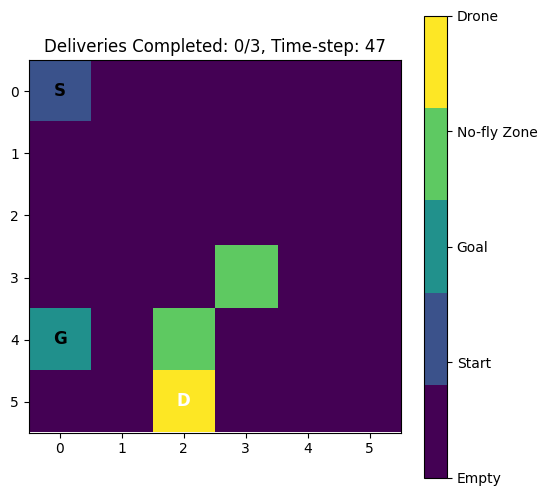

State: (5, 2, 0), Reward: -1


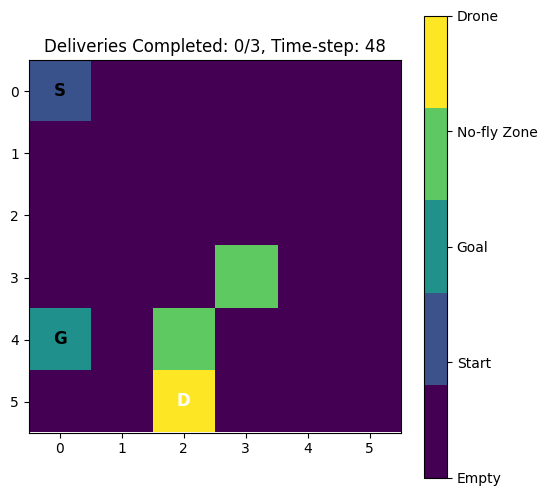

State: (4, 2, 0), Reward: -20


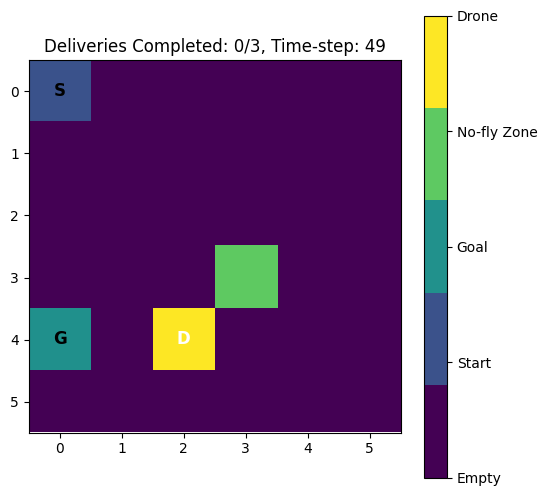

State: (4, 1, 0), Reward: -1


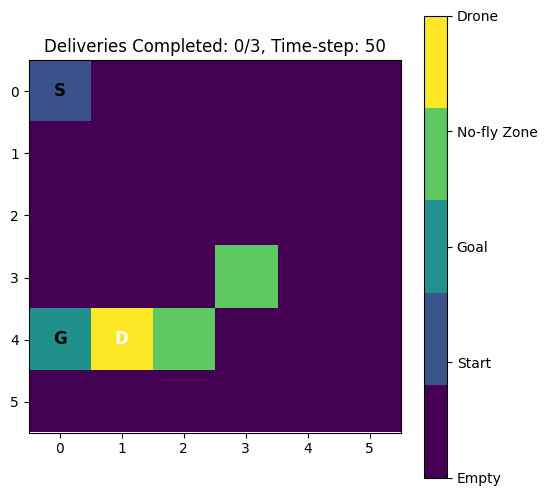

In [205]:
if __name__ == "__main__":
    env = MultiDeliveryDroneEnv(max_deliveries=3, deterministic=True)
    state = env.reset()
    print("Multiple Deliveries Environment:")

    for _ in range(50):
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        print(f"State: {state}, Reward: {reward}")
        env.render()

## Part 2

In [206]:
# Agent QLearning

import pickle
import random

class QLearningAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.1):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.epsilon_min = epsilon_min  # Minimum epsilon value

        # Initialize Q-table with zeros
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        """Choose action using epsilon-greedy policy"""
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(0, self.action_size)  # Random action (explore)
        return np.argmax(self.q_table[state])  # Best action (exploit)

    def update_q_table(self, state, action, reward, next_state):
        """Update Q-values using Bellman Equation"""
        best_future_q = np.max(self.q_table[next_state])
        current_q = self.q_table[state, action]
        self.q_table[state, action] = current_q + self.alpha * (reward + self.gamma * best_future_q - current_q)

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save_q_table(self, filename):
        """Save Q-table as a pickle file"""
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

    def load_q_table(self, filename):
        """Load Q-table from a pickle file"""
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)


def train_q_learning(env, agent, num_episodes=1000):
    rewards_per_episode = []
    epsilon_values = []

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state[0] * env.grid_size + state[1]
        total_reward = 0

        done = False
        while not done:
            action = agent.choose_action(state_index)
            next_state, reward, done, _ = env.step(action)
            next_state_index = next_state[0] * env.grid_size + next_state[1]

            agent.update_q_table(state_index, action, reward, next_state_index)

            state_index = next_state_index
            total_reward += reward

        rewards_per_episode.append(total_reward)
        epsilon_values.append(agent.epsilon)
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{num_episodes}: Reward = {total_reward}")
    return rewards_per_episode, epsilon_values


def evaluate_q_learning(env, agent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state[0] * env.grid_size + state[1]
        total_reward = 0
        done = False

        while not done:
            action = np.argmax(agent.q_table[state_index])  # Greedy action
            state, reward, done, _ = env.step(action)
            state_index = state[0] * env.grid_size + state[1]
            total_reward += reward

        total_rewards.append(total_reward)

    return total_rewards


def plot_results(rewards, epsilon_values, evaluation_rewards):
    episodes = range(len(rewards))

    # Total Rewards per Episode
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episodes, rewards, label="Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward Per Episode")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(episodes, epsilon_values, label="Epsilon Decay", color="red")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.title("Epsilon Decay Over Time")
    plt.legend()
    plt.show()

    # Evaluation Rewards
    plt.figure(figsize=(6, 5))
    plt.plot(range(len(evaluation_rewards)), evaluation_rewards, marker='o', label="Evaluation Rewards", color="green")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Evaluation of Greedy Policy")
    plt.legend()
    plt.show()



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 50
Episode 100/1000: Reward = 41
Episode 150/1000: Reward = 66
Episode 200/1000: Reward = 80
Episode 250/1000: Reward = 95
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 95
Episode 400/1000:

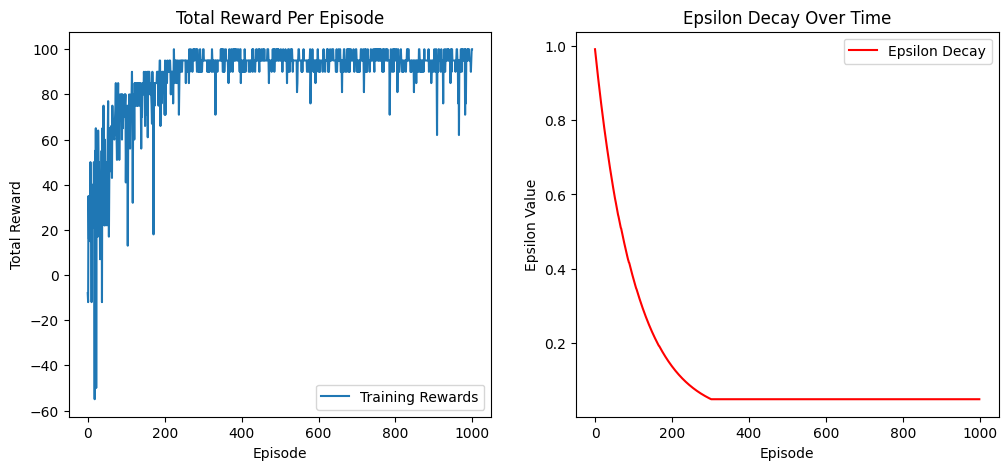

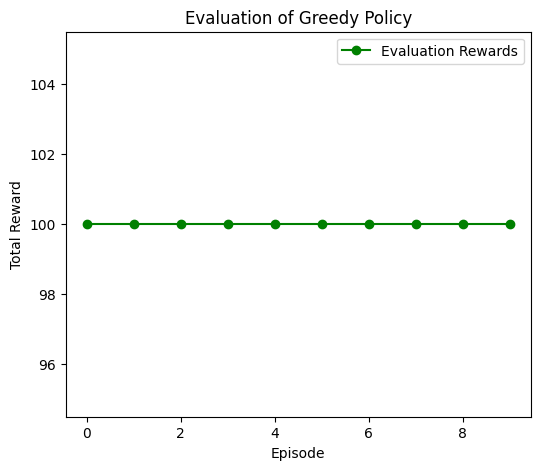

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 31
Episode 100/1000: Reward = 65
Episode 150/1000: Reward = 90
Episode 200/1000: Reward = 85
Episode 250/1000: Reward = 85
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 90
Episode 400/1000:

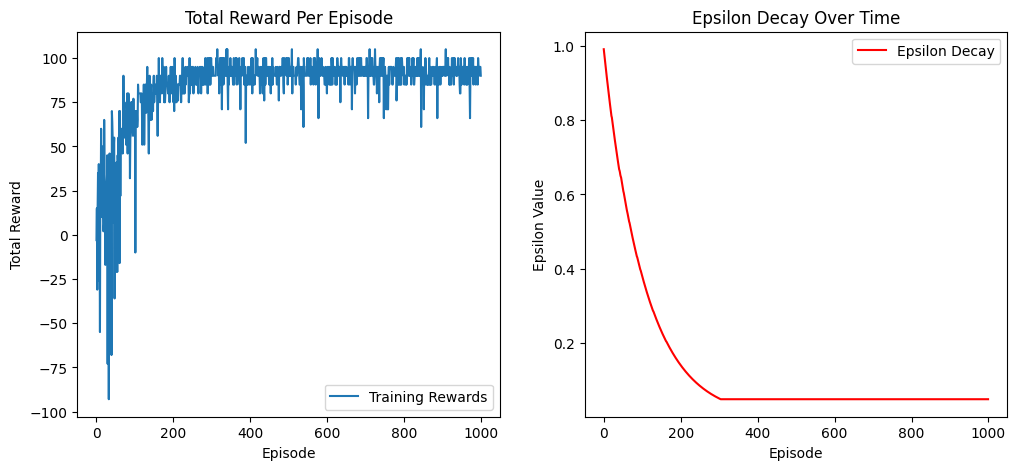

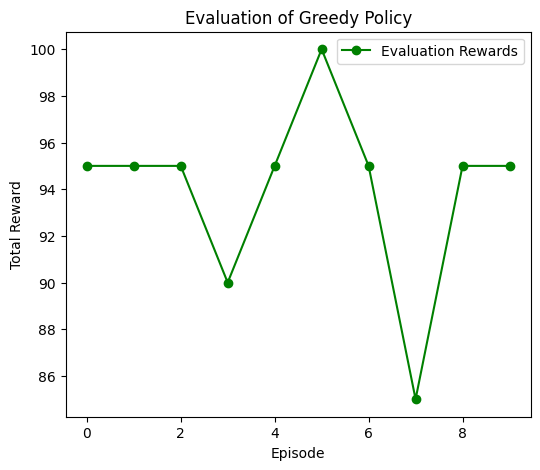

In [207]:
# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9998,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_deterministic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)



# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9998,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

###Hyper-Parameter Tuning


### Hyperparameter #1 - Changing Gamma values

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 76
Episode 100/1000: Reward = 100
Episode 150/1000: Reward = 95
Episode 200/1000: Reward = 95
Episode 250/1000: Reward = 95
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 95
Episode 400/1000

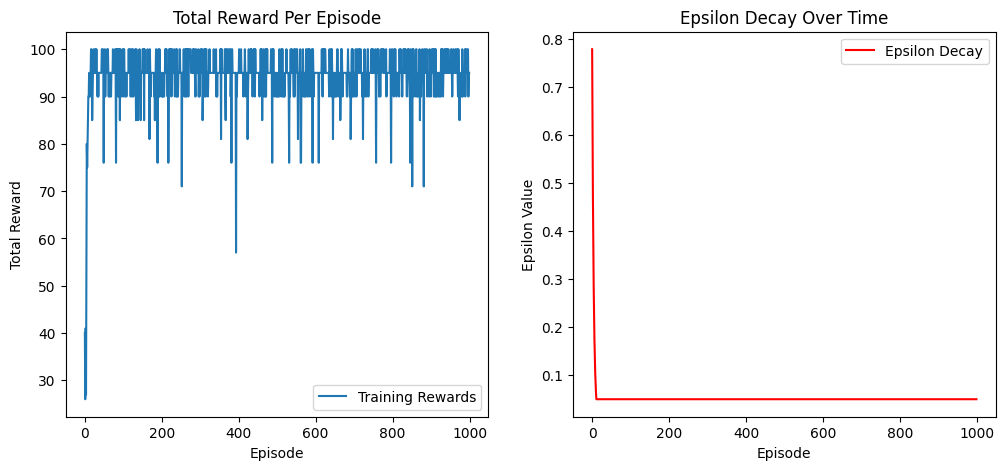

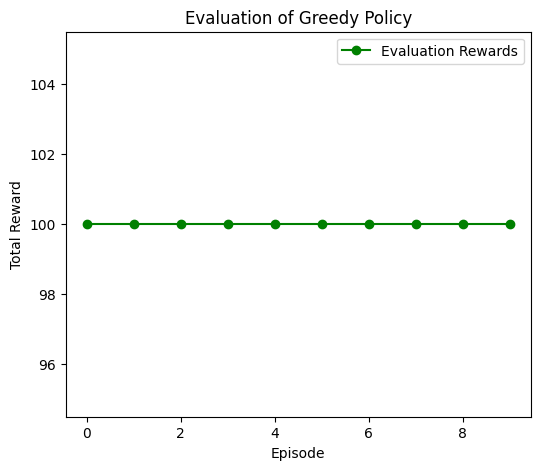

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 90
Episode 100/1000: Reward = 90
Episode 150/1000: Reward = 90
Episode 200/1000: Reward = 105
Episode 250/1000: Reward = 90
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 90
Episode 400/1000

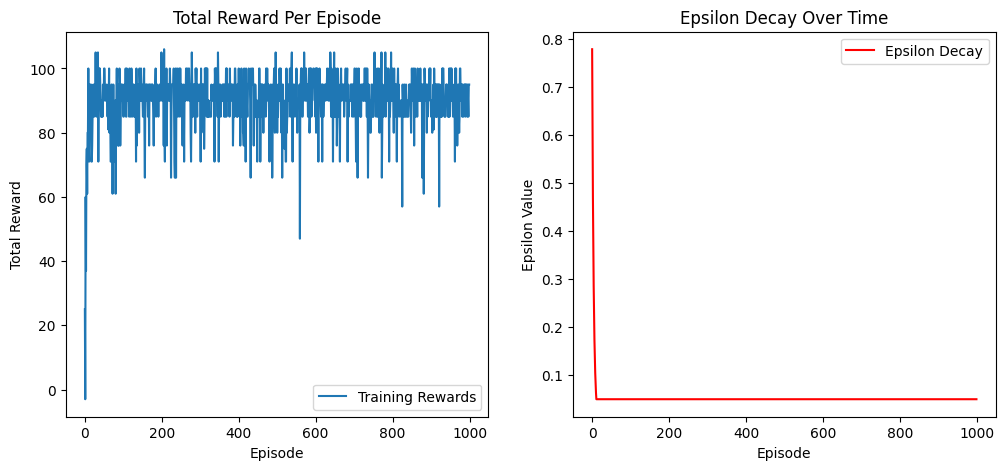

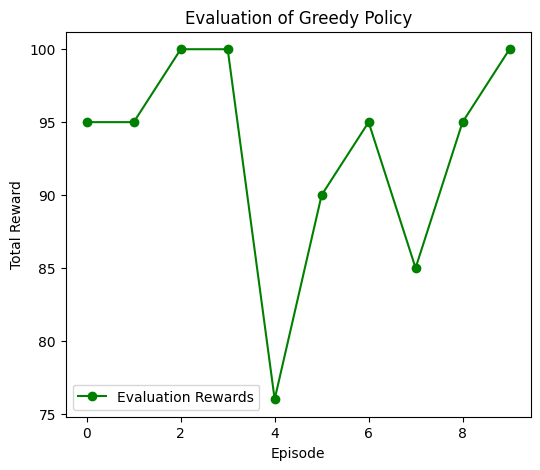

In [209]:
# gamma = 0.99, epsilon = 0.995

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 90
Episode 100/1000: Reward = 95
Episode 150/1000: Reward = 95
Episode 200/1000: Reward = 95
Episode 250/1000: Reward = 100
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 95
Episode 400/1000

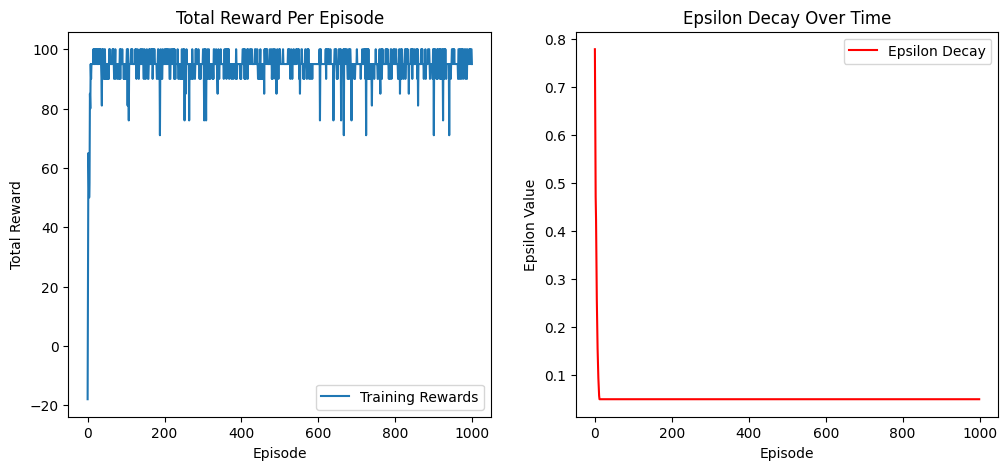

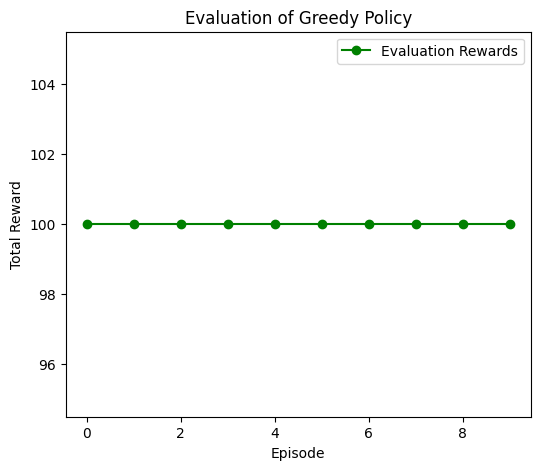

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 95
Episode 100/1000: Reward = 90
Episode 150/1000: Reward = 85
Episode 200/1000: Reward = 90
Episode 250/1000: Reward = 95
Episode 300/1000: Reward = 85
Episode 350/1000: Reward = 80
Episode 400/1000:

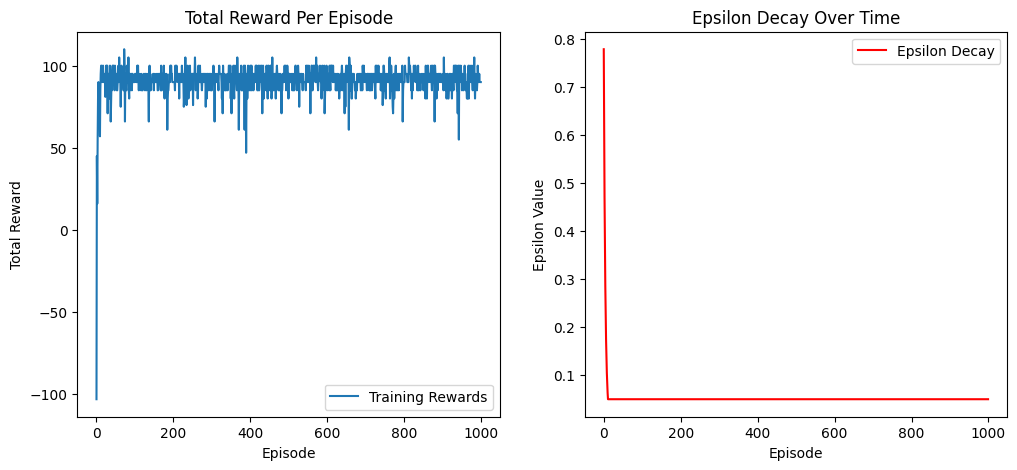

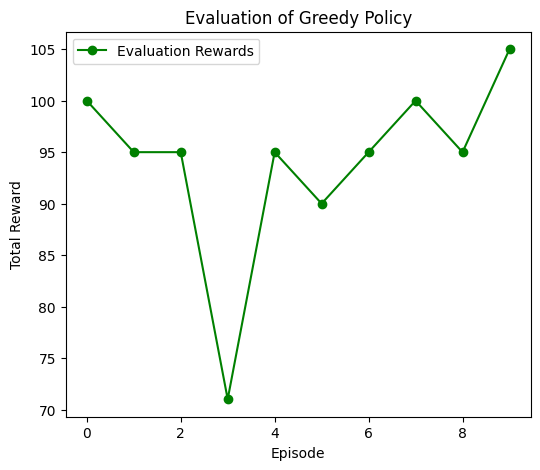

In [210]:
# gamma = 0.95, epsilon = 0.995

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 95
Episode 100/1000: Reward = 95
Episode 150/1000: Reward = 100
Episode 200/1000: Reward = 95
Episode 250/1000: Reward = 95
Episode 300/1000: Reward = 95
Episode 350/1000: Reward = 90
Episode 400/1000

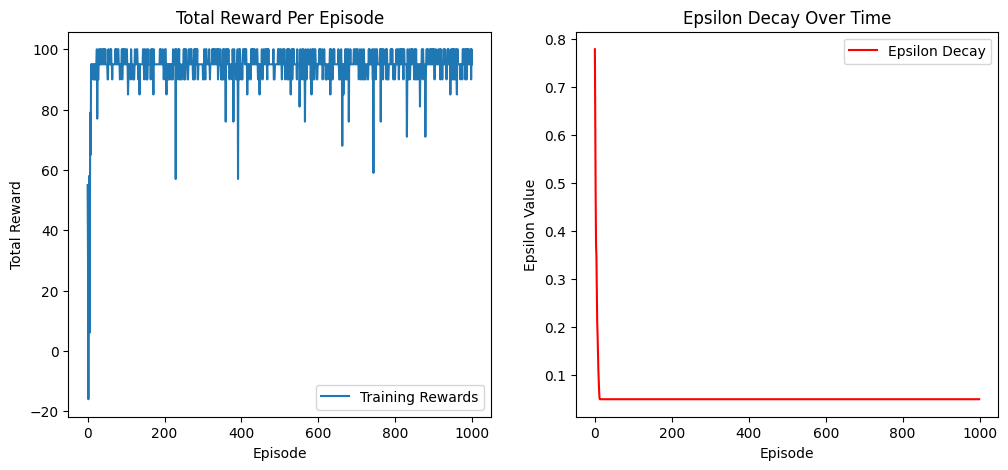

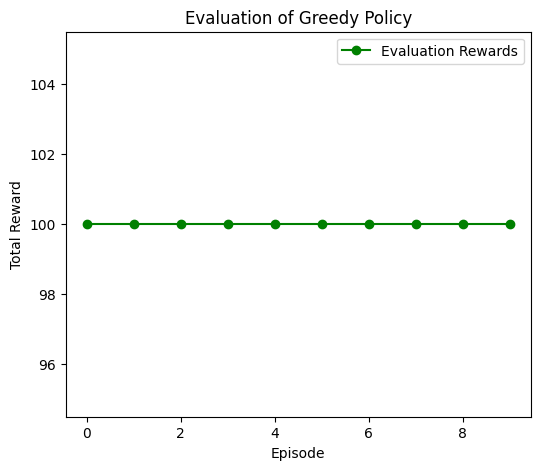

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 66
Episode 100/1000: Reward = 90
Episode 150/1000: Reward = 90
Episode 200/1000: Reward = 71
Episode 250/1000: Reward = 90
Episode 300/1000: Reward = 71
Episode 350/1000: Reward = 90
Episode 400/1000:

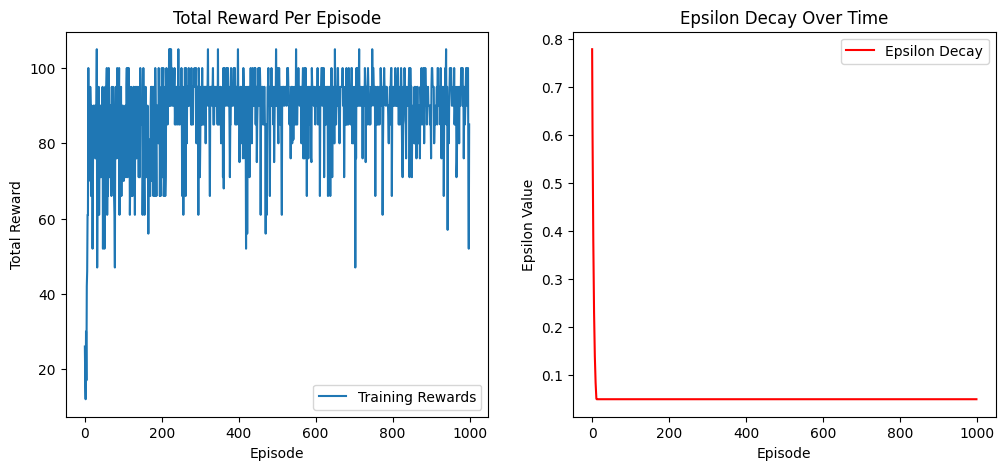

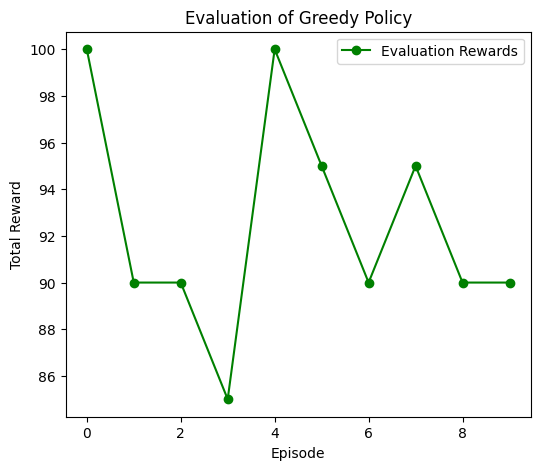

In [ ]:
# gamma = 0.80, epsilon = 0.995

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.80,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.80,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

### Hyperparameter #2 - Changing Epsilon values

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 55
Episode 100/1000: Reward = 37
Episode 150/1000: Reward = 66
Episode 200/1000: Reward = 85
Episode 250/1000: Reward = 90
Episode 300/1000: Reward = 90
Episode 350/1000: Reward = 100
Episode 400/1000

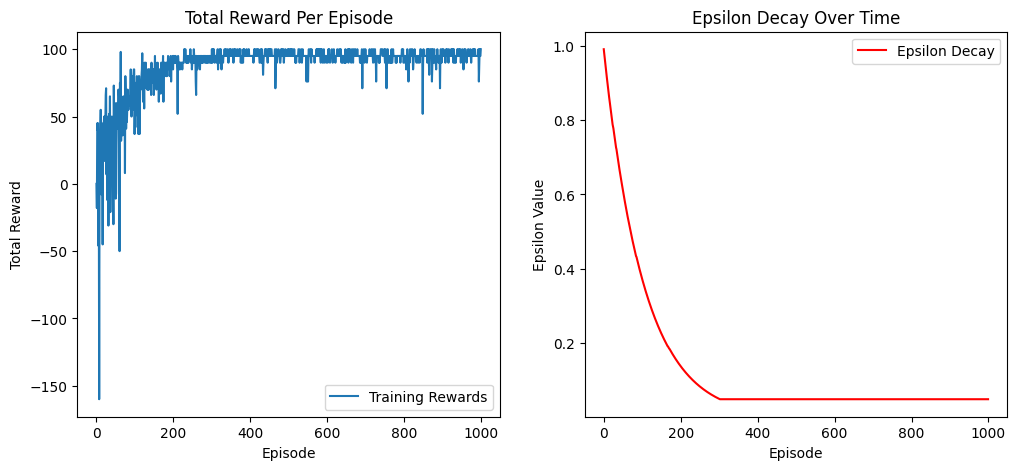

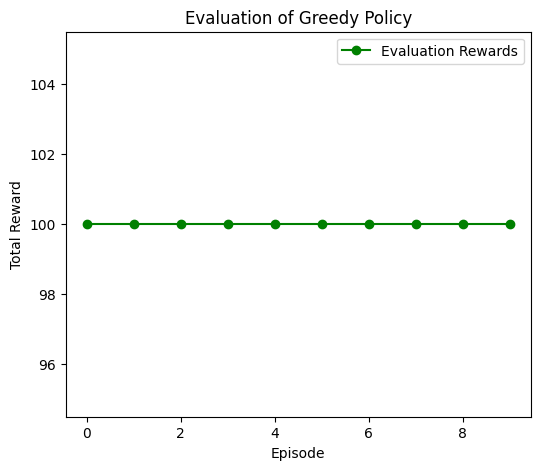

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 8
Episode 100/1000: Reward = -1
Episode 150/1000: Reward = 80
Episode 200/1000: Reward = 85
Episode 250/1000: Reward = 85
Episode 300/1000: Reward = 100
Episode 350/1000: Reward = 95
Episode 400/1000:

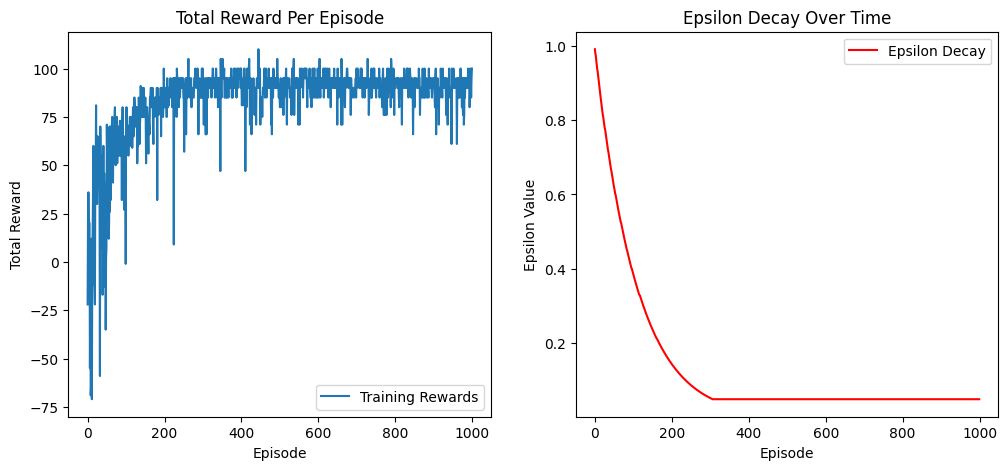

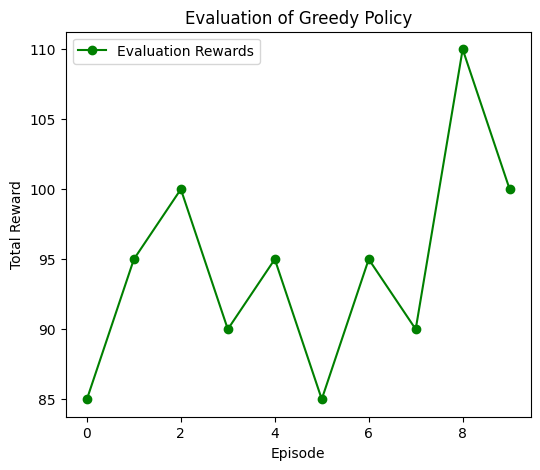

In [ ]:
# gamma = 0.99, epsilon = 0.9998

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9998,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9998,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 42
Episode 100/1000: Reward = 76
Episode 150/1000: Reward = 85
Episode 200/1000: Reward = 76
Episode 250/1000: Reward = 100
Episode 300/1000: Reward = 85
Episode 350/1000: Reward = 95
Episode 400/1000

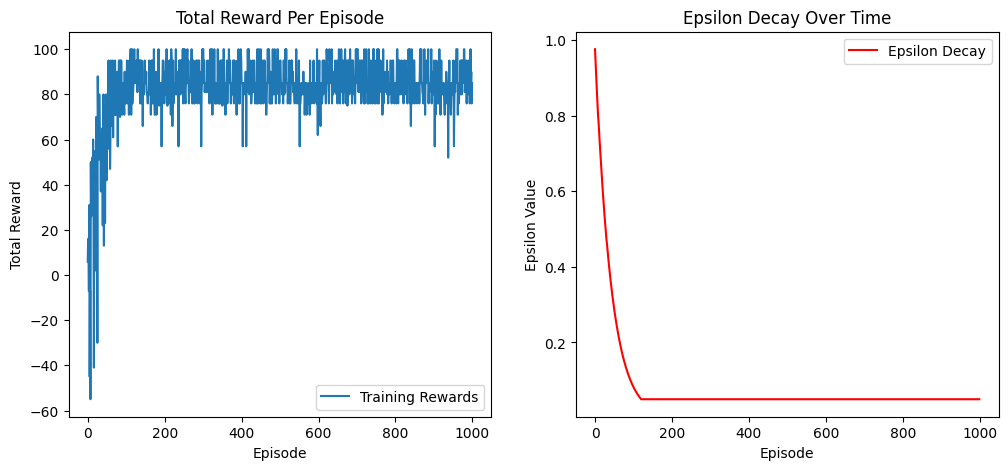

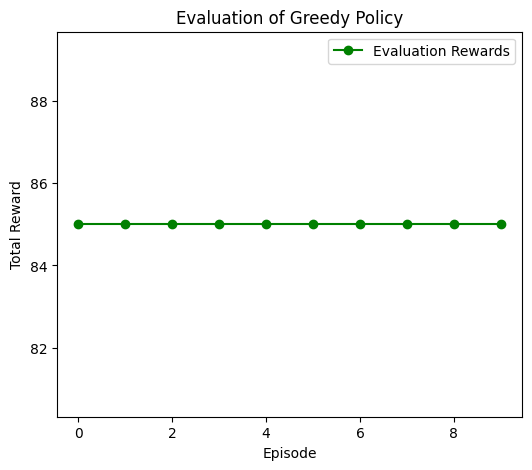

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 56
Episode 100/1000: Reward = 80
Episode 150/1000: Reward = 90
Episode 200/1000: Reward = 95
Episode 250/1000: Reward = 95
Episode 300/1000: Reward = 105
Episode 350/1000: Reward = 90
Episode 400/1000

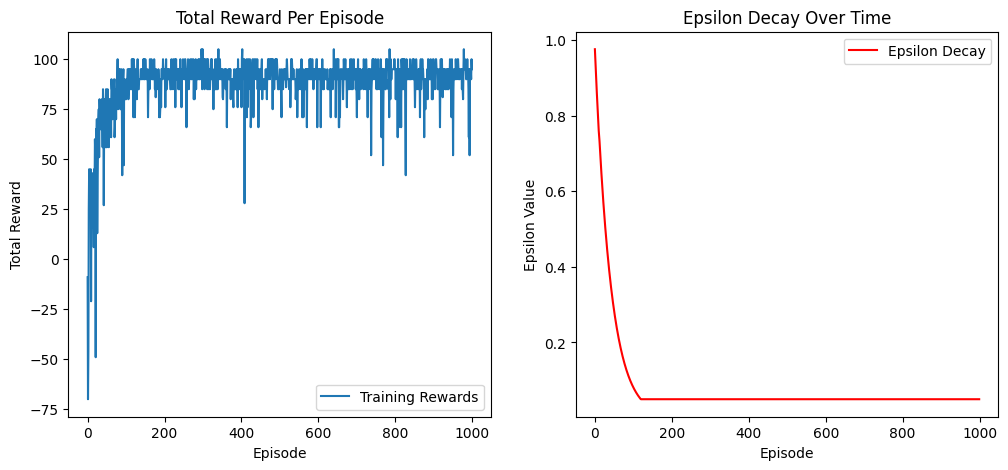

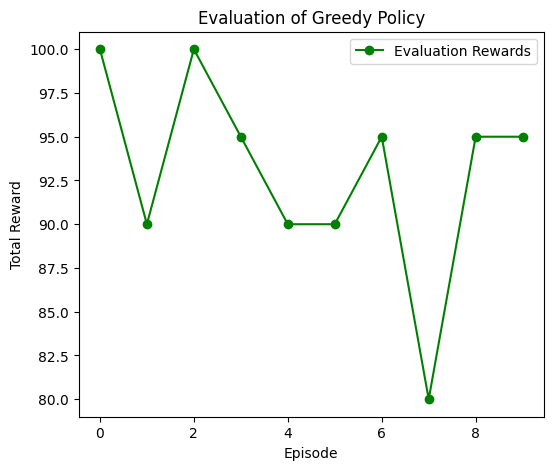

In [213]:
# gamma = 0.99, epsilon = 0.9995

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9995,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 95
Episode 100/1000: Reward = 90
Episode 150/1000: Reward = 95
Episode 200/1000: Reward = 95
Episode 250/1000: Reward = 90
Episode 300/1000: Reward = 71
Episode 350/1000: Reward = 100
Episode 400/1000

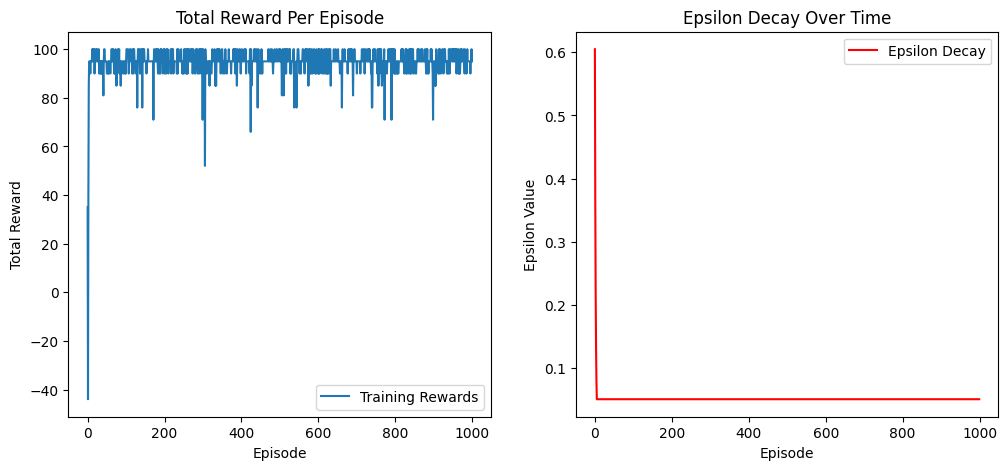

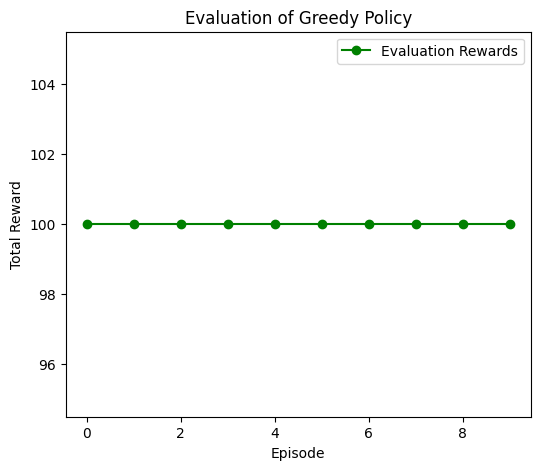

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Episode 50/1000: Reward = 85
Episode 100/1000: Reward = 57
Episode 150/1000: Reward = 85
Episode 200/1000: Reward = 90
Episode 250/1000: Reward = 95
Episode 300/1000: Reward = 100
Episode 350/1000: Reward = 95
Episode 400/1000

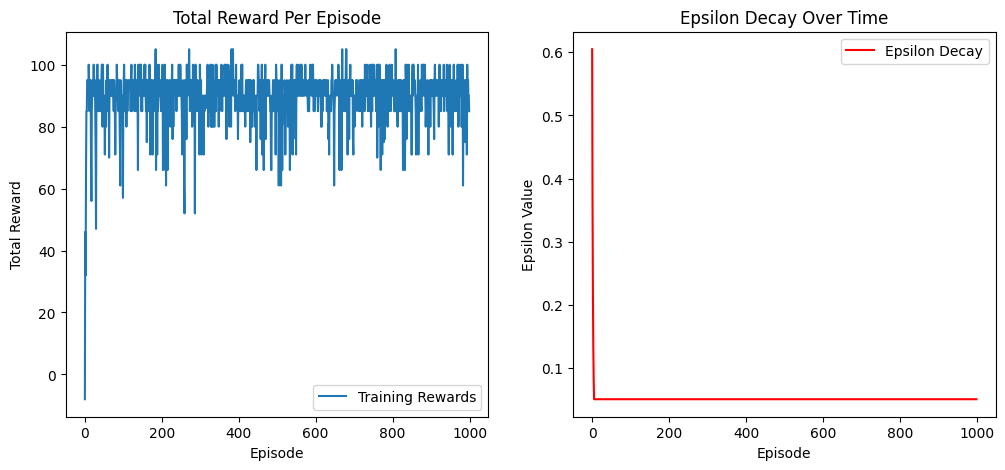

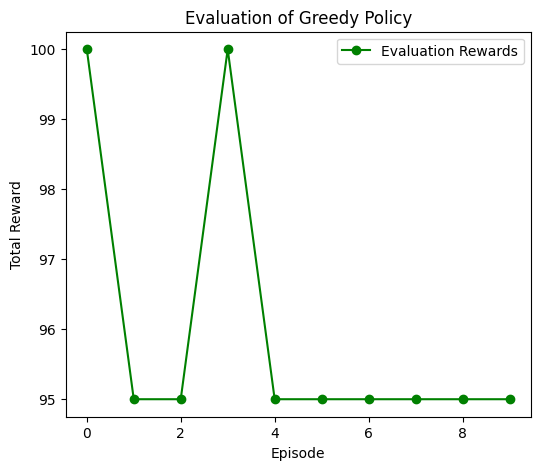

In [214]:
# gamma = 0.99, epsilon = 0.99

# Deterministic Method - Q Learning
if __name__ == "__main__":
    env = DroneDeliveryEnv(deterministic=True)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.99,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)


# Stochastic method - Q Learning
    env = DroneDeliveryEnv(deterministic=False)

    agent = QLearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.05,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.99,
        epsilon_min=0.05
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_q_learning(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table("qtable_qlearning_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_q_learning(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

### Other Tabular Method - SARSA

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Trained Q-table:
[[ 7.00904523e+01  1.01376380e+02  5.40467289e+01  3.26881034e+01
   5.13968414e+01  5.88598299e+01]
 [-1.90000000e-01  6.29112839e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  3.18779146e+00]
 [ 0.00

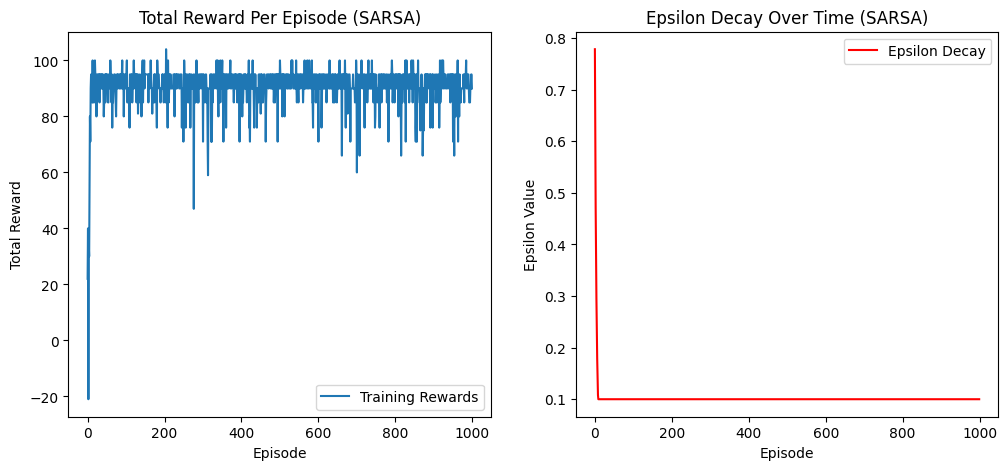

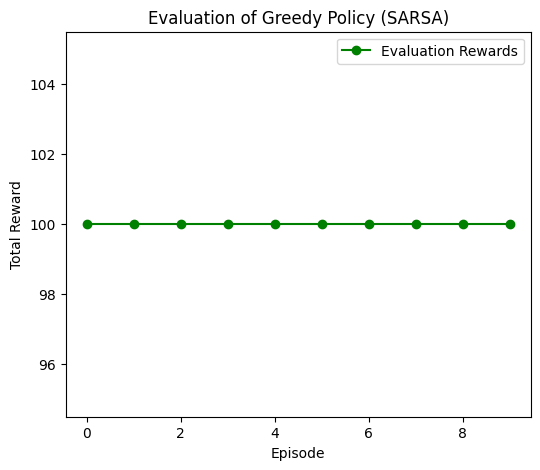

Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Trained Q-table:
[[ 5.32060923e+01  8.66014642e+01  4.39900602e+01  3.92581504e+01
   6.10159243e+01  4.86634083e+01]
 [ 3.55144452e+00  0.00000000e+00  9.87889817e+00  6.82678879e+01
   1.13342815e-01  5.73054963e+00]
 [ 1.43

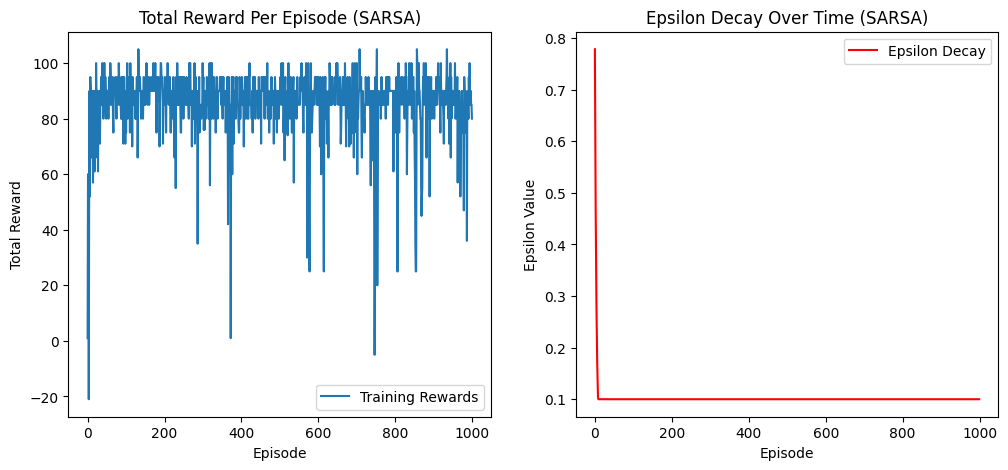

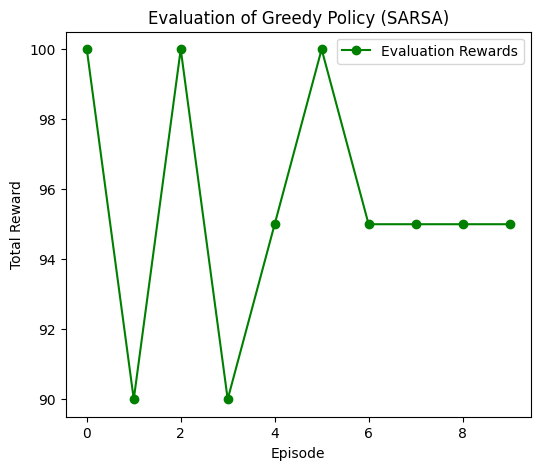

In [215]:
class SARSALearningAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.90, epsilon=1.0, epsilon_decay=0.9995, epsilon_min=0.1):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        """Choose action using epsilon-greedy policy"""
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(0, self.action_size)  # Random action (explore)
        return np.argmax(self.q_table[state])  # Best action (exploit)

    def update_q_table(self, state, action, reward, next_state, next_action):
        """Update Q-values using SARSA update rule"""
        current_q = self.q_table[state, action]
        next_q = self.q_table[next_state, next_action]
        self.q_table[state, action] = current_q + self.alpha * (reward + self.gamma * next_q - current_q)

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save_q_table_pickle(self, filename):
        """Save Q-table as a pickle file"""
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

    def load_q_table_pickle(self, filename):
        """Load Q-table from a pickle file"""
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)

    def save_q_table_h5(self, filename):
        """Save Q-table as an H5 file"""
        with h5py.File(filename, 'w') as f:
            f.create_dataset('q_table', data=self.q_table)

    def load_q_table_h5(self, filename):
        """Load Q-table from an H5 file"""
        with h5py.File(filename, 'r') as f:
            self.q_table = np.array(f['q_table'])


def train_sarsa(env, agent, num_episodes=500):
    rewards_per_episode = []
    epsilon_values = []

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state[0] * env.grid_size + state[1]
        action = agent.choose_action(state_index)
        total_reward = 0

        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_state_index = next_state[0] * env.grid_size + next_state[1]
            next_action = agent.choose_action(next_state_index)

            agent.update_q_table(state_index, action, reward, next_state_index, next_action)

            state_index = next_state_index
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)
        epsilon_values.append(agent.epsilon)

    return rewards_per_episode, epsilon_values


def evaluate_sarsa(env, agent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state[0] * env.grid_size + state[1]
        total_reward = 0
        done = False

        while not done:
            action = np.argmax(agent.q_table[state_index])  # Greedy action
            state, reward, done, _ = env.step(action)
            state_index = state[0] * env.grid_size + state[1]
            total_reward += reward

        total_rewards.append(total_reward)

    return total_rewards


def plot_results(rewards, epsilon_values, evaluation_rewards):
    episodes = range(len(rewards))

    # Total Rewards per Episode
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episodes, rewards, label="Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward Per Episode (SARSA)")
    plt.legend()

    # Epsilon Decay
    plt.subplot(1, 2, 2)
    plt.plot(episodes, epsilon_values, label="Epsilon Decay", color="red")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.title("Epsilon Decay Over Time (SARSA)")
    plt.legend()
    plt.show()

    # Evaluation Rewards
    plt.figure(figsize=(6, 5))
    plt.plot(range(len(evaluation_rewards)), evaluation_rewards, marker='o', label="Evaluation Rewards", color="green")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Evaluation of Greedy Policy (SARSA)")
    plt.legend()
    plt.show()


if __name__ == "__main__":
# Deterministic method
    env = DroneDeliveryEnv(deterministic=True)

    agent = SARSALearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_sarsa(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table_pickle("qtable_sarsa_deterministic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_sarsa(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)

# Stochastic method
    env = DroneDeliveryEnv(deterministic=False)

    agent = SARSALearningAgent(
        state_size=env.grid_size**2,
        action_size=env.action_space.n,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995
    )

    print("Initial Q-table:")
    print(agent.q_table)

    rewards, epsilon_values = train_sarsa(env, agent, num_episodes=1000)

    print("Trained Q-table:")
    print(agent.q_table)

    # Save Q-table
    agent.save_q_table_pickle("qtable_sarsa_stochastic_method.pkl")

    # Evaluate greedy policy
    eval_rewards = evaluate_sarsa(env, agent, num_episodes=10)

    # Plot results
    plot_results(rewards, epsilon_values, eval_rewards)



## Part 3 - Solve Stock Trading Environment

In [216]:
import pandas as pd
file_path = '/content/drive/MyDrive/RL Dataset/NVDA.csv'
df = pd.read_csv(file_path)
df.head()

Date    Open       High     Low   Close  Adj Close     Volume
0  2022-07-01  14.899  15.063000  14.392  14.523  14.506663  577610000
1  2022-07-05  14.175  14.971000  14.055  14.964  14.947166  651397000
2  2022-07-06  15.010  15.319000  14.789  15.130  15.112980  529066000
3  2022-07-07  15.456  15.945000  15.389  15.858  15.840160  492903000
4  2022-07-08  15.430  16.037001  15.389  15.838  15.820185  467972000

In [ ]:
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt

class StockTradingEnv:
    def __init__(self, file_path, train=True, number_of_days_to_consider=5):
        self.data = pd.read_csv(file_path)
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        self.data.set_index('Date', inplace=True)

        self.train = train
        self.number_of_days = number_of_days_to_consider
        self.initial_capital = 100000
        self.current_step = 0
        self.stock_held = False
        self.stock_price = 0
        self.cash = self.initial_capital
        self.total_value = self.initial_capital
        self.account_values = []

        self.data['Trend'] = self.data['Close'].rolling(window=self.number_of_days).mean().diff() > 0

    def reset(self):
        self.current_step = 0
        self.stock_held = False
        self.stock_price = 0
        self.cash = self.initial_capital
        self.total_value = self.initial_capital
        self.account_values = [self.total_value]
        return self.get_observation(), {}

    def get_observation(self):
        if self.current_step < self.number_of_days:
            return 0
        price_increase = self.data['Trend'].iloc[self.current_step]
        if price_increase and not self.stock_held:
            return 0
        elif price_increase and self.stock_held:
            return 1
        elif not price_increase and not self.stock_held:
            return 2
        else:
            return 3

    def step(self, action):
        done = False
        reward = 0
        if self.current_step >= len(self.data) - 1:
            done = True
            return self.get_observation(), reward, done, False, {}

        current_price = self.data['Close'].iloc[self.current_step]

        if action == 0:  # Buy
            if not self.stock_held:
                self.stock_held = True
                self.stock_price = current_price
            else:
                reward -= 5

        elif action == 1:  # Sell
            if self.stock_held:
                profit = current_price - self.stock_price
                self.cash += profit
                reward += profit
                self.stock_held = False
            else:
                reward -= 5

        elif action == 2:  # Hold
            reward += 0

        self.total_value = self.cash + (current_price if self.stock_held else 0)
        self.account_values.append(self.total_value)
        self.current_step += 1

        return self.get_observation(), reward, done, False, {}

    def render(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.account_values, label="Account Value Over Time")
        plt.xlabel("Days")
        plt.ylabel("Total Account Value ($)")
        plt.title("Agent's Portfolio Performance")
        plt.legend()
        plt.show()




/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [218]:
class QLearningAgent:
    def __init__(self, state_size=4, action_size=3, alpha=0.2, gamma=0.95, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        self.q_table[state, action] = self.q_table[state, action] + \
            self.alpha * (reward + self.gamma * self.q_table[next_state, best_next_action] - self.q_table[state, action])

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save_q_table(self, filename='qtable_stock_trading.pkl'):
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

    def load_q_table(self, filename='qtable_stock_trading.pkl'):
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)


def train_q_learning_agent(env, agent, episodes=500):
    rewards_per_episode = []
    epsilon_values = []

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
        epsilon_values.append(agent.epsilon)
        agent.decay_epsilon()

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{episodes}: Reward = {total_reward:.2f}")

    agent.save_q_table()
    print("Training complete. Q-table saved.")

    # Epsilon Decay
    plt.figure(figsize=(10, 5))
    plt.plot(epsilon_values, label="Epsilon Decay")
    plt.xlabel("Episodes")
    plt.ylabel("Epsilon Value")
    plt.title("Epsilon Decay Over Time")
    plt.legend()
    plt.show()

    # Total Reward per Episode
    plt.figure(figsize=(10, 5))
    plt.plot(rewards_per_episode, label="Total Reward")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Reward Per Episode During Training")
    plt.legend()
    plt.show()


def evaluate_agent(env, agent):
    agent.load_q_table()
    state, _ = env.reset()
    done = False
    initial_capital = env.initial_capital

    while not done:
        action = np.argmax(agent.q_table[state])  # Greedy Action
        state, _, done, _, _ = env.step(action)

    env.render()

    final_value = env.total_value
    final_profit = final_value - initial_capital
    roi = ((final_value - initial_capital) / initial_capital) * 100
    print(f"Final Portfolio Value: ${final_value:.2f}, Profit: ${final_profit:.2f}, ROI: {roi:.2f}%")
    return final_profit, roi





Episode 50/1000: Reward = -402.23
Episode 100/1000: Reward = -242.02
Episode 150/1000: Reward = -57.33
Episode 200/1000: Reward = -76.43
Episode 250/1000: Reward = 15.34
Episode 300/1000: Reward = 6.47
Episode 350/1000: Reward = 30.18
Episode 400/1000: Reward = 38.46
Episode 450/1000: Reward = 22.42
Episode 500/1000: Reward = 53.13
Episode 550/1000: Reward = -6.03
Episode 600/1000: Reward = 32.88
Episode 650/1000: Reward = 40.26
Episode 700/1000: Reward = 59.34
Episode 750/1000: Reward = 66.30
Episode 800/1000: Reward = 59.82
Episode 850/1000: Reward = 24.71
Episode 900/1000: Reward = 12.58
Episode 950/1000: Reward = 12.17
Episode 1000/1000: Reward = 34.71
Training complete. Q-table saved.


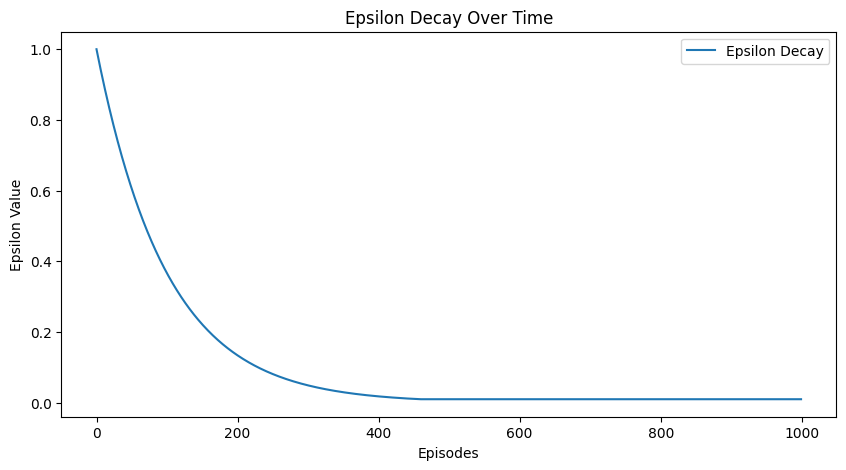

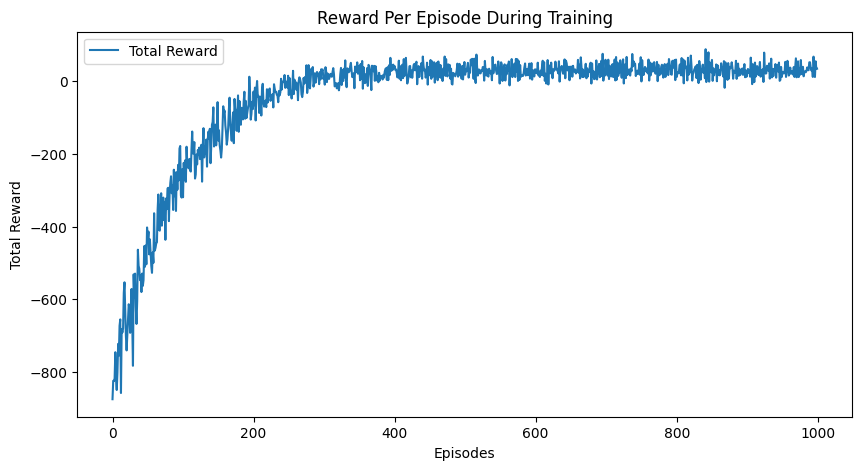

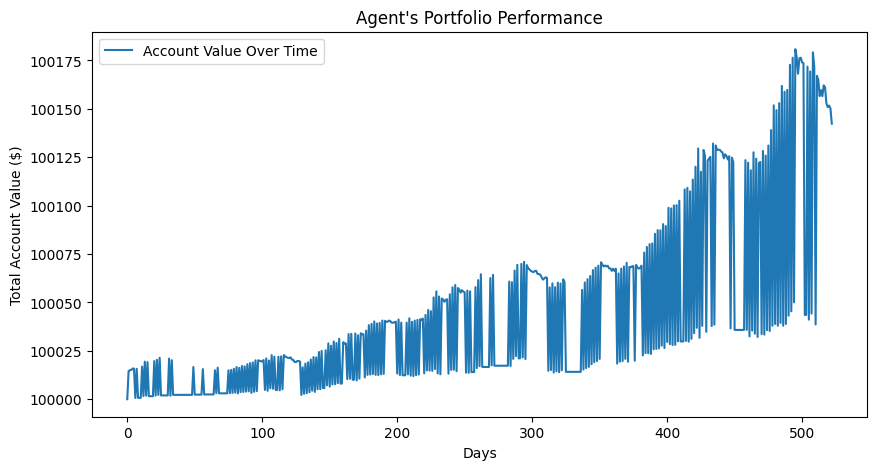

Final Portfolio Value: $100142.35, Profit: $142.35, ROI: 0.14%


In [ ]:
if __name__ == "__main__":
    env = StockTradingEnv(file_path, train=True, number_of_days_to_consider=5)
    agent = QLearningAgent()

    # Train agen
    train_q_learning_agent(env, agent, episodes=1000)

    # Evaluate trained agent
    env = StockTradingEnv(file_path, train=False, number_of_days_to_consider=5)
    evaluate_agent(env, agent)